# parsing configuration file

In [1]:
import configparser


In [13]:
confParser = configparser.ConfigParser()

In [14]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#--- set dynamic parameters
temp=confParser['parameters']['temperature']
load=confParser['parameters']['load']
confParser.set('input files','fileName',''.join([
               'Swapped_%s.dump '%temp, #0
               'equilibrium_%s.dump '%temp, #1
               'dump.shearedge5k_Sheng5_anealed_%sload '%load, #2
               'dump.shearedge5k_Sheng-non3_%sload '%load, #3
               'quench_%s.dump '%temp, #4
               'quench_NotAnnealed_%s.dump '%temp, #5
               'Swapped_600_edge.dump ', #6
               'equilib_600_edge.dump ', #7
               'dumpSheared.xyz ', #8
               'indented.dump ',    #9
               'anneled_compressed_011.dump ',    #10
               'Annealed_tension_011.dump ',    #11
               'Annealed_before_indentation.dump ',    #12
               'anneled_before_compression.dump ',    #13
               'RSS_before_indentation.dump ',    #14
               'RSS_compressed.dump ',    #15
                'swapped.dump ', #16
                'Atoms_dyn.dump ', #17
                'Swapped_300.dump ', #18
                'annealing.dump ', #19
                'Atoms_dyn.dat ', #20
              ]))


conf. file sections: ['parameters', 'flags', 'neigh list', 'dislocation analysis', 'irradiation', 'input files', 'py library path', 'Atomic Radius']


# import libraries

In [4]:
#--- system libraries
import sys
sys.path.append(confParser['py library path']['py_lib'])
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
#from backports 
import fnmatch
import json
from json import JSONEncoder
import functools as ftl

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
#
warnings.filterwarnings('ignore')
#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
# from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '/home/karimik/Project/git/HeaDef/postprocess/utilityy.py'>

In [22]:
class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,**kwargs):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5 if not 'capsize' in kwargs else kwargs['capsize'],
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

In [23]:
DRAW_FRAME=(0.23,0.08,0.12,0.07,0.1)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    



# Dump File

In [77]:
path = confParser['input files']['path']
print('list dir:',os.listdir(path))
indx = confParser['input files']['fileIndex']
fileName = confParser['input files']['filename'].split()[int(indx)]
#--- dump files
print('parsing %s/%s'%(path,fileName))
lmpData = lp.ReadDumpFile( '%s/%s'%(path,fileName) ) 
lmpData.GetCords( ncount = sys.maxsize, sort = False,
#                 columns = {'c_1[1]':'sxx','c_1[2]':'syy','c_1[3]':'szz',
#                                                   'c_1[4]':'sxy','c_1[5]':'sxz','c_1[6]':'syz'} 
                  columns = {'c_spatom[1]':'sxx','c_spatom[2]':'syy','c_spatom[3]':'szz',
                             'c_spatom[4]':'sxy','c_spatom[5]':'sxz','c_spatom[6]':'syz'}
                )
keys = list(lmpData.coord_atoms_broken.keys())
keys.sort()
print('time steps:',keys)
itime0 = keys[0]
display(lmpData.coord_atoms_broken[itime0].head())


list dir: ['swapped.dump']
parsing ../lammpsRuns/nicocrNatom100KMultipleTempIrradiatedAnneal/dpa2/temp0/Run0/swapped.dump
reached end of file!
time steps: [0, 20000]


,id,type,x,y,z,fx,fy,fz,c_1[1],c_1[2],c_1[3],c_1[4],c_1[5],c_1[6]
0,76957,2,2.9824,1.06340,3.628700,0.04343,-0.4000,-0.4306,803900.0,344400.0,325300.0,-325700.0,-937700.0,-353100.0
1,86483,3,1.1895,2.80170,0.062046,0.16330,-0.8390,-0.1444,580400.0,1236000.0,1147000.0,-213600.0,399200.0,-120200.0
2,91961,1,1.2917,0.98025,1.951600,-1.25700,0.7459,-0.3905,-621100.0,-815700.0,-843600.0,405300.0,308600.0,-333700.0
3,97289,2,2.8802,0.91751,0.102710,0.33780,0.5731,-0.3598,178600.0,-160900.0,-265400.0,-275000.0,238400.0,209300.0
4,97291,1,1.0543,2.93050,3.575000,1.02500,-0.7331,0.6281,-327100.0,-737700.0,-912400.0,-174500.0,-63660.0,38110.0


In [193]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
#list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


## stress response

In [194]:
def GetStrsStrain( lmpData, col='sxy' ):

#     fig = plt.figure( figsize = (4,4))
#     ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\epsilon_{xy}$',fontsize=16)
#     ax.set_ylabel(r'$%s$(Gpa)'%col,fontsize=16)
#     ax.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
#     ax.set_xlim(0,0.05)
#     ax.set_ylim(Virial[0],0.5)
#     ax.plot(
# #        sorted(times),
#          0.5*np.array(strainDump),
#         Virial, '-')
#     #
#     plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
#     plt.show()
    #
    return np.array(strainDump), Virial
    
if eval(confParser['flags']['StrsCurve']):
    strain, stress = GetStrsStrain( lmpData,
                  col='sxy',
                 )
    utl.PltErr(0.5*strain,stress,
               attrs={'fmt':'-'},
              xlim=(0,0.05),
#               ylim=(stress[0],0.5),
               xstr=r'$\epsilon_{xy}$',
               ystr=r'$\sigma_{xy}$',
               title='stress.png'
              )

In [195]:
def GetStrsStrain( lmpData, col='sxy' ):

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax2=ax.twinx()
    #
    ax.set_xlabel(r'$\sigma_{xy}$(Gpa)',fontsize=16)
    ax2.set_ylabel(r'$\dot\gamma_{xy}$',fontsize=16)
    ax.set_ylabel(r'$\gamma_{xy}$',fontsize=16)
    #
    ax2.set_yscale('log')
    #
    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False
    #        virial = -(np.sum(atoms.sxx)+np.sum(atoms.syy)+np.sum(atoms.szz)) / 3.0 / volume

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
    ax.plot(
            sorted(Virial),
            strainDump, '-',label=r'$\gamma_{xy}$')
    ax2.plot(
            sorted(Virial),
            np.gradient(strainDump,sorted(times)), 
            '-',color='red',label=r'$\dot\gamma_{xy}$')
    #
    plt.legend(fontsize=16)
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    #

if eval(confParser['flags']['StrsCurve']):
    GetStrsStrain( lmpData,
              col='sxy',
             )


In [196]:
def GetStrsStrain( filee, xcol, ycol, **kwargs ):
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'%s(ps)'%xcol,fontsize=16)
    ax.set_ylabel(r'%s(Gpa)'%ycol,fontsize=16)
    #
    ax.tick_params(labelsize=16)
    #
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs['xlim'])
    #
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs['ylim'])
    #
    if 'xscale' in kwargs:
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs:
        ax.set_yscale(kwargs['yscale'])
    #
    df = pd.read_csv(filee,sep=' ')
    try:
        ax.plot(
                df[xcol],
                df[ycol], '-')
    except:
        if ycol == 'wxy':
            ax.plot(
                    df[xcol],
                    np.gradient(df['exy'],df['time']), 
                    '-',color='red',label=r'$\dot\gamma_{xy}$')
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

if eval(confParser['flags']['StrsCurve']):

    GetStrsStrain( '%s/temperature.txt'%path,
                   xcol = 'time',
                   ycol = 'sxy',

                 )

    GetStrsStrain( '%s/temperature.txt'%path,
                   xcol = 'time',
                   ycol = 'exy',
                  xlim=np.array([0.0,.8])*10000,
                  ylim=[0.0,0.04]             
                 )

    GetStrsStrain( '%s/temperature.txt'%path,
                   xcol = 'time',
                   ycol = 'wxy',
                  xlim=np.array([0.0,0.8])*10000,
                  ylim=[-1e-3,1e-2],
                  xscale = 'linear', yscale = 'linear',
                 )

## parse data

In [197]:
#itimee=np.sum(list(lmpData.coord_atoms_broken.keys())) #--- only two timesteps:[0,ntime]
keys=list(lmpData.coord_atoms_broken.keys())
keys.sort()

itimee=keys[-1] #--- only two timesteps:[0,ntime]
itime0=keys[0]
atomsRf = lp.Atoms( **lmpData.coord_atoms_broken[itime0].to_dict(orient='series') )
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='series') )
    #
box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ) )
#box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    
display(pd.DataFrame(atoms.__dict__).head())
pd.DataFrame(atomsRf.__dict__).head()


,id,type,x,y,z,fx,fy,fz,c_1[1],c_1[2],c_1[3],c_1[4],c_1[5],c_1[6]
0,1,3,109.41,43.495,106.76,-0.04988,0.892200,-0.02294,-721200.0,854800.0,751100.0,244700.0,-44610.0,-481100.0
1,2,3,116.49,38.444,108.34,0.17410,-0.217700,0.69270,66960.0,867500.0,686000.0,48530.0,-221600.0,-392000.0
2,3,3,116.40,40.219,106.64,0.67160,0.196700,0.35370,61960.0,18900.0,-576500.0,171800.0,-243000.0,277800.0
3,4,3,118.44,36.699,101.37,-0.53360,0.006403,-0.03366,82070.0,-357500.0,501800.0,57790.0,128600.0,200300.0
4,5,2,114.82,29.449,101.35,-0.40290,0.365500,0.07081,-1409000.0,-1313000.0,-1639000.0,-240900.0,193100.0,-125600.0


,id,type,x,y,z,fx,fy,fz,c_1[1],c_1[2],c_1[3],c_1[4],c_1[5],c_1[6]
0,1,3,109.42,43.800,106.42,-0.035440,-0.14010,1.41800,1842000.0,425800.0,1159000.0,-1019000.0,1223000.0,135000.0
1,2,1,116.64,38.328,108.55,0.153900,-0.01833,-0.53990,-1232000.0,-972700.0,-799800.0,-95180.0,285500.0,-347400.0
2,3,1,116.64,40.228,106.69,-0.001604,-0.57540,0.43860,499500.0,502800.0,193500.0,145300.0,4604.0,-49970.0
3,4,3,118.35,36.430,101.44,0.176000,0.67670,0.02689,1125000.0,583900.0,1065000.0,-30890.0,-329400.0,-529800.0
4,5,2,114.87,29.402,101.43,-0.449000,0.15630,0.17610,-265400.0,-568900.0,-201100.0,92860.0,-54090.0,297900.0


## removed atom

In [198]:
# atom_id=np.sum(atomsRf.id)-np.sum(atoms.id)
# print('atom_id=',atom_id)
# zz=pd.DataFrame(atomsRf.__dict__)[pd.DataFrame(atomsRf.__dict__)['id']==atom_id]['z'].iloc[0]

In [199]:
# PrintOvito( pd.DataFrame(atomsDiff.__dict__), 
#             open( 'strsDiff.xyz','w'), 
#             footer = 'ITIME=%s'%itimee,
#             attr_list=['id','type','x','y','z','sxx' ,'syy' ,'szz' ,'sxy' ,'sxz' ,'syz'] )

# Displacements

In [200]:
if eval(confParser['flags']['Displ']):
    !ovitos OvitosCna.py $fileName Disp.xyz $nevery 4
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Disp.xyz' )
    ovtData.GetCords( ncount = sys.maxsize, 
                     columns = {'DisplacementX':'ux','DisplacementY':'uy','DisplacementZ':'uz'} )
    #
    disp = lp.Atoms( **ovtData.coord_atoms_broken[itimee].to_dict(orient='series'))


# Voronoi Analysis

In [201]:
if eval(confParser['flags']['VorAnl']):
    !mkdir voranl

    path = confParser['input files']['path']
    indx = confParser['input files']['fileIndex']
    fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
    nevery = int(confParser['parameters']['nevery'])
    types = list(map(int,confParser['Atomic Radius']['type'].split()))
    radius = list(map(float,confParser['Atomic Radius']['radius'].split()))
    AtomicRadius = dict(zip(types,radius))
        
    rad1=AtomicRadius[1]
    rad2=AtomicRadius[2]
    rad3=AtomicRadius[3]
    !ovitos OvitosCna.py $fileName voranl/Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'voranl/Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)

# Press. Fluc

In [202]:
!mkdir PressFluc

mkdir: PressFluc: File exists


In [203]:
def StrsDiff(atoms,atomsRf):
    atomsDiff = lp.Atoms( **pd.DataFrame(atoms.__dict__).copy().to_dict(orient='series'))
    atoms0 = lp.Atoms( **pd.DataFrame(atomsRf.__dict__).copy().to_dict(orient='series'))
    #--- virial energy to stress
    for key in ['sxx','syy','szz']:#,'sxy','syz','sxz']:
        atomsDiff.__dict__[key] /= atomsDiff['AtomicVolume']
        atoms0.__dict__[key] /= atoms0['AtomicVolume']
    df=pd.DataFrame(atoms0.__dict__).set_index('id').loc[atoms.id]
    #--- stress change
#    for key in ['sxx','syy','szz','sxy','syz','sxz','AtomicVolume']:
#        atomsDiff.__dict__[key] -= np.array((df[key]).tolist())
        
    #--- volumetric strain
#    atomsDiff.AtomicVolume /= atoms0.AtomicVolume
#    display(pd.DataFrame(atomsDiff.__dict__))
    return atomsDiff

if eval(confParser['flags']['PressFluc']):
    #--- fetch radii
    radii=list(map(float,confParser['Atomic Radius']['radius'].split()))
    types=list(map(int,confParser['Atomic Radius']['type'].split()))
    AtomicRadius=dict(zip(types,radii))
    #
    itime = 0
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[itime]['type'])),
                       AtomicVolume = ovtData.coord_atoms_broken[itime]['AtomicVolume'].tolist(),
                    )
    #---
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[0]['type'])),
                       AtomicVolume = ovtData.coord_atoms_broken[0]['AtomicVolume'].tolist(),
                    )

    display(pd.DataFrame(atoms.__dict__).head())
    
    #--- pressure change
    atomd=StrsDiff(atoms,atoms0) #--- atomd.sxx has units of stress 
    #--- filter abs(dv)>0
    atomd = lp.Atoms( **pd.DataFrame(atomd.__dict__)[np.abs(atomd.AtomicVolume)>1.0e-10].to_dict(orient='series'))
    display(pd.DataFrame(atomd.__dict__).head())

## Scatter plot

In [204]:
def PlotScatter(atomd,**kwargs):
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    #
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    y=np.array(atomd.sxx)+np.array(atomd.syy)+np.array(atomd.szz)
    y *= (-1.0e-4/3.0)
    x = np.array(atomd.AtomicVolume)
    
    cxy=0.0
    if 'zscore' in kwargs and kwargs['zscore']:
        x = Zscore(x)
        y = Zscore(y)
        cxy = np.sum(x*y)/len(x)
    for elm,indxx,col in zip(['Ni','Co','Cr'],[1,2,3],['black','red','green']):
        filtr = np.array(atomd.type) == indxx
        ax.scatter(np.abs(x[filtr]),np.abs(y[filtr]),
                   alpha=.1,c=col,label=elm)#,marker='x')
    #
    ax.legend(frameon=False, fontsize=12)
    #
#     DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    PutMinorTicks( ax, LOGY = True, LOGX=True)
    #
    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    return cxy
    
if eval(confParser['flags']['PressFluc']) and\
   eval(confParser['flags']['VorAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- scatter plot of press and volumetric strain
    cxy = PlotScatter(atomd,
#               zscore = True,
#               xlim=[1e-7,1e-3,1e-8,1e4],
               Logx=True, Logy=True,
               ylabel = r'$|\Delta p|$(Gpa)',
               xlabel = r'$|\epsilon_v|$',
               )
    np.savetxt('PressFluc/PressVolCrltn.txt',[cxy],header='<p.v>')

## Mean pressure

In [205]:
if eval(confParser['flags']['PressFluc']):
    press=np.sum(np.array(atoms.sxx)+np.array(atoms.syy)+np.array(atoms.szz))
    vol = np.linalg.det(box.CellVector)
    press *= (-1.0e-4/3.0/vol)

    press0=np.sum(np.array(atoms0.sxx)+np.array(atoms0.syy)+np.array(atoms0.szz))
    vol = np.linalg.det(box.CellVector)
    press0 *= (-1.0e-4/3.0/vol)

    print('dp=',press-press0)
    np.savetxt('PressFluc/PressChange.txt',[press-press0],header='DeltaPress')


### multiple frames

In [206]:
if not eval(confParser['flags']['RemoteMachine']):
    sarr = MultipleFrames2nd( path='NiCoCrNatom100KTakeOneOutRlxd', title='PressChange.txt', nrun = 16, ncols=1 ).flatten()

    plt.hist(sarr,bins=16)
    plt.show()
    
    print(sarr.mean(),sarr.std()/np.abs(sarr.mean()))

In [207]:
# fraci = np.logspace(np.log10(0.1),np.log10(0.9),8)
# for ifrac, fracc in zip(range(1000),fraci):
#     sarr  = MultipleFrames2nd(path='HeaNiCoCrNatom10KTakeOneOutFreezeFract%sRlxd'%ifrac,
#                               nrun=32,title='PressVolCrltn.txt',ncols=1).flatten()
#     indices = ~np.isnan( sarr )
#     sarr = sarr[ indices ]
#     plt.scatter([fracc]*len(sarr),-sarr,color='C0')
# plt.show()

## distortions

### equilibrium?

In [208]:
if eval(confParser['flags']['PressFluc']):

    #--- timesteps
    times =  list(lmpData.coord_atoms_broken.keys())
    times.sort()
    ntime=len(times)

    #--- plot
    ax=utl.PltErr(None,None,Plot=False)


    #--- loop over time
    for itime in times[int(ntime/2):ntime]:
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series'),
                          rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[itime]['type'])),
                           AtomicVolume = ovtData.coord_atoms_broken[itime]['AtomicVolume'].tolist(),
                        )

        hist1, edges1, error1 = GetPDF( atoms.AtomicVolume, 
                                         linscale = True, 
                                         n_per_decade=12,
                                         density = True,
                                                    )

        utl.PltErr(edges1,hist1,
                       yerr=error1,
                        markevery=1,markersize=9,
                        yscale='log',
                        xscale='linear',
                        marker='o',
                       ax=ax,
            #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                            ylim=(1e-4,1e1),
                            xlim=(10,13),
    #                        title='PressFluc/pdfNiLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],
                      )

In [209]:
if eval(confParser['flags']['PressFluc']):
    #--- plot
    symbols=Symbols()
    lg = Legends()
    lg.Set(fontsize=16,
           bbox_to_anchor=(0.0,0.48,0.5,0.5),
          )
    ax=utl.PltErr(None,None,Plot=False)

    #--- initialize
    std = np.zeros(3)
    meann = np.zeros(3)

    
    times =  list(lmpData.coord_atoms_broken.keys())
    times.sort()

    #--- loop over types
    for atom_type, count, ll in zip([1,2,3],range(3),['Ni','Co','Cr']):    
        #--- fetch volumes
        itime = times[-1]
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series'),
                          rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[itime]['type'])),
                           AtomicVolume = ovtData.coord_atoms_broken[itime]['AtomicVolume'].tolist(),
                        )

        #--- histograms
        filtr = atoms.type == atom_type

        hist1, edges1, error1 = GetPDF( pd.DataFrame(atoms.__dict__)[filtr].AtomicVolume, 
                                         linscale = True, 
                                         n_per_decade=12,
                                         density = True,
                                                    )

        #--- std
        std[count] = np.std(pd.DataFrame(atoms.__dict__)[filtr].AtomicVolume)
        meann[count] = np.mean(pd.DataFrame(atoms.__dict__)[filtr].AtomicVolume)
        temp = eval(confParser['parameters']['temperature'])

        #--- plot
        utl.PltErr(edges1,hist1,
                       yerr=error1,
                        yscale='log',
                        xscale='linear',
                       ax=ax,
                        attrs=symbols.GetAttrs(count=count,label='%s'%ll,fmt='.-'),      
                   #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                            ylim=(1e-3,1e1),
                            xlim=(10.5,12),
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],
                      )
    utl.PltErr(None,None,
#               legend=lg.Get(),
               ax=ax,
               yscale='log',
                title='PressFluc/hist_vorVolumeTemp%sRss.png'%confParser['parameters']['temperature'],
                DrawFrame=[0.2,0.1,0.15,0.1,0.01],
              )


    #--- save
    np.savetxt('PressFluc/voronoiFluctuationsTemp%sRss.txt'%temp,np.c_[np.concatenate(([temp],std))].T,header='Temp\tstdNi\tstdCo\tstdCr')
    np.savetxt('PressFluc/voronoiAverageTemp%sRss.txt'%temp,np.c_[np.concatenate(([temp],meann))].T,header='Temp\tmeanNi\tmeanCo\tmeanCr')


In [210]:
if eval(confParser['flags']['PressFluc']) and not\
   eval(confParser['flags']['RemoteMachine']):
    #--- plot order parameter vs. distance
    temperature = []
    meann = []
    for temp, count in zip([400,600,800,1000,1200,1400],range(100)): #--- T
        pathh = 'NiCoCrNatom100KDistortions/Temp%s/Run0/PressFluc/voronoiAverageTemp%s.txt'%(temp,temp)
        print('parse from %s'%pathh)
        sdata = np.loadtxt(pathh)
        #--- filter
        #--- order parameter
        temperature.append(sdata[0])
        meann.append(sdata[1:])
            #--- mean y
    print(temperature)
    #--- parse rss
    pathh = 'PressFluc/voronoiAverageTemp5Rss.txt'
    print('parse from %s'%pathh)
    sdata = np.loadtxt(pathh)
    #--- filter
    #--- order parameter
#        temperature.append(sdata[0])
    mean_rss = sdata[1:]
    print(mean_rss)
    
    #--- plot
    ax = utl.PltErr(None,None,Plot=False)
    for count in range(3):
        utl.PltErr(temperature,np.c_[meann][:,count],
                   attrs=symbols.GetAttrs(count=count),
                   ax=ax,
                   Plot=False,

                  )
        utl.PltErr([1500],mean_rss[count],
                   attrs=symbols.GetAttrs2nd(count=count),
                   ax=ax,
                   Plot=False,
                    title='PressFluc/voronoiAverageTempSro.png',
                    DrawFrame=[0.2,0.1,0.15,0.1,0.01],
                   xlim=(300,1600),
                xticks=(['$500$','$1000$',''],[500,1000,1500])
                  )

In [211]:
if not eval(confParser['flags']['RemoteMachine']):
    ax = utl.PltErr(None,None,Plot=False)
    for count in range(3):
        utl.PltErr(temperature,np.c_[stdd][:,count]/np.c_[meann][:,count],
                   attrs=symbols.GetAttrs(count=count),
                   ax=ax,
                   Plot=False,

                  )
        utl.PltErr([1500],std_rss[count]/mean_rss[count],
                   attrs=symbols.GetAttrs2nd(count=count),
                   ax=ax,
                   Plot=False,
                    title='PressFluc/voronoiStdTempSro.png',
                    DrawFrame=[0.2,0.1,0.15,0.1,0.01],
                   xlim=(300,1600),
                    xticks=(['$500$','$1000$',''],[500,1000,1500])
                  )

## pressure decay

### map

In [212]:
def Intrp( d2min, box0,times, time0, Plot = None ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.3, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

    if Plot:
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        #--- xy plane
        zz=0.5*(zlin[-1]+zlin[0])
        dz = zlin[-1]-zlin[-2]
        lz = zlin[-1]-zlin[0]
        nzz=int(nz*(zz-zlin[0])/lz)
        val = value[:,:,nzz].copy()
#        pdb.set_trace()

        np.savetxt('pressBitmap.txt',val)

        PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = True,
                  frac = 0.5, #--- plot a patch
                  title = 'd2min.png',
                  colorbar=True,
                )

    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp
  
if not eval(confParser['flags']['RemoteMachine']):
    junk, (xv, yv, zv), d2intrp = Intrp(atoms, box,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                   )

#### map and scatterd plot 

In [213]:
def PltBitmapWithScatter( value, xyScatter,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              ticklabels=True,
              color='black',
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4*aspect))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
    if not ticklabels:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=color,marker='x',s=10)
        
        
    if colorbar:
        ax.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
def Intrp( d2min, box0,times, time0, title = 'bitmap', Plot = None ):
    d2intrp = {}
    for itime in times:
        #--- mean dist between atoms 
        natoms = len( d2min.x ) 
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


        #--- grid tiling mapped box with original size
        #--- values are interpolated onto this grid
        (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                         box0.CellVector, 
                                                         dmean,
                                                         margin = 0.0 * dmean )
        xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

        #--- expand the original box
            #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
        cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
        d2exp = cptmp.Get()

        points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
        values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0] #--- corresponding values

        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

        #--- make an object
        d2intrp[ itime ] = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

        if Plot:
        #--- reshape value
            nx,ny,nz = len(xlin), len(ylin),len(zlin) 
            value = np.c_[d2intrp[ itime ].d2min].reshape(((ny,nx,nz)))

            CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
            #--- xy plane
#            zz=0.0
            zc=0.5*(zlin[0]+zlin[-1])
            dz = zlin[-1]-zlin[-2]
            lz = zlin[-1]-zlin[0]
            #
            zz = [zc,zlin[-1]][1]
            nzz=int(nz*(zz-zlin[0])/lz)
            if nzz == nz: nzz -= 1
            val = value[:,:,nzz].copy()
#            pdb.set_trace()
        
#            np.savetxt('pressBitmap.txt',val)

#             PltBitmap(val, 
#                       xlabel = 'x', ylabel = 'y',
#                       xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#                       zscore = True,
#                       frac = 1.0, #--- plot a patch
#                  title = '%s%s.png'%(title,itime),
#                       colorbar=True,
#                     )
            
            #--- filter
            zlo=(zz-dz-zlin[0]) % lz + zlin[0]
            zhi=(zz+dz-zlin[0]) % lz + zlin[0]

            indxx= np.all([d2min.z > zlo, 
                           d2min.z < zhi
                          ],
                            axis=0)
            
            if zhi < zlo: #--- periodicity
                indxx= np.any([d2min.z > zlo, 
                               d2min.z < zhi
                              ],
                                axis=0)


            indices = d2min.type == 1 #--- Ni 3
            indxx = np.all([indxx,indices],axis=0)

            PltBitmapWithScatter(val, 
                  np.c_[np.array(d2min.x)[indxx],np.array(d2min.y)[indxx]],
                  xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                  xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                  zscore = True,
                  frac = 1.0, #--- plot a patch
                  title = '%s%s.png'%(title,itime),
                  colorbar=None,
                  ticklabels = None,
                  color='black',
    #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                  )
                
                

    return (xlin, ylin, zlin), (xv[:,:,:], yv[:,:,:], zv[:,:,:]), d2intrp
  
if not eval(confParser['flags']['RemoteMachine']):
    #--- local pressure and Ni atoms
    junk, (xv, yv, zv), d2intrp = Intrp(atoms0, box,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                    title = 'cr',
                   )

#### average map

In [214]:
if not eval(confParser['flags']['RemoteMachine']):
    nruns=16
    for irun in range(nruns):
        val=np.loadtxt('NiCoCrNatom100KTakeOneOutRlxd/Run%s/pressBitmap.txt'%irun)
        if irun == 0:
            valm = val.copy()
        else:
            valm += val
    valm /= nruns

    PltBitmap(valm, 
              xlabel = '', ylabel = '',
    #          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = 'd2min.png',
              colorbar=True,
    #          DrawFrame=[0.3,0.3,0.3,0.1,0.1],
            )

### scaling

In [215]:
def GetCR( X, Y, Z, zfield, DIR, tol=1e-3, title='decay.png',**kwargs ):
    if 'xc' in kwargs:
        X = X.copy()
        Y = Y.copy()
        Z = Z.copy()
        xc = kwargs['xc']
        X -= xc[0]
        Y -= xc[1]
        Z -= xc[2]
    xyz = np.c_[X,Y,Z]
    xyzNorm = np.array(list(map(lambda x: np.sum(x)**.5,xyz*xyz)))
    #
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.tick_params(labelsize=18)
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)
    #
    for ndir in DIR:
        dot = np.sum(xyz * ndir,axis=1) / np.sum(ndir*ndir)**0.5 / xyzNorm
        assert np.all([-1.0<=dot,dot<=1.0])
        #
        indices= np.abs(1.0-dot) < tol
        #
        xx=X[indices]
        yy=Y[indices]
        zz=Z[indices]
    #    print(np.c_[xx,yy,zz])
        #
        rr=np.sqrt(xx*xx+yy*yy+zz*zz)
        rho = zfield[indices]
        assert len( rr ) > 0 
        assert len(rho[np.isnan(rho)]) == 0
        #
        slist=list(zip(rr,rho))
        slist.sort()
        rr = [i[0] for i in slist]
        rho = [i[1] for i in slist]
        ax.plot(rr,rho,'-o',label=r'%s'%ndir)
#        print(np.c_[rr,rho])
    #
    #--- draw power law
    if 'alpha' in kwargs:
        alpha = kwargs['alpha']
        xx=ax.lines[0].get_data()[0]
        xx.sort()
        xx = np.array(xx)
        ax.plot(ax.axis()[0]*(xx/xx[0]),ax.axis()[3]*(xx[0]/xx)**alpha,'-.r',label='$r^{-%s}$'%alpha)
        #
        ax.legend(frameon=False, fontsize=16)
    #--- save
    if 'Logy' in kwargs and kwargs['Logy']:
        PutMinorTicks(ax, LOGY=True)
    if 'Logx' in kwargs and kwargs['Logx']:
        PutMinorTicks(ax, LOGX=True)
    #DrawFrame(ax, 0.3,0.3,0.3,0.1,0.1)
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    
    
if not eval(confParser['flags']['RemoteMachine']):

    #--- decay of local pressure
    valm = -1.0e-4*(atoms.sxx+atoms.syy+atoms.szz)/atoms.AtomicVolume/3.0 #--- corresponding values
    GetCR( atoms.x, atoms.y, atoms.z, valm, 
    #      np.array([[1.0,1.0,0.0],[-1.0,1.0,0.0],[-1.0,-1.0,0.0],[1.0,-1.0,0.0]] ),
    #      np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[-1.0,0.0,0.0],[0.0,-1.0,0.0]] ),
          np.array([[0.0,1.0,0.0]]),#,[1.0,1.0,0.0]] ),
          xc=np.array([28.6,0.0,0.0]), #--- origin
          xlabel=r'$r$(\r{A})',
          ylabel =r'$\Delta p$(Gpa)',
          xlim=(1e1,1e2,1e-1,2),
           Logy = True,
           Logx = True,
          alpha=1,
         )






In [216]:
if not eval(confParser['flags']['RemoteMachine']):

    #--- decay of local pressure
    GetCR( disp.x, disp.y, disp.z, -disp.ux, 
          np.array([[1.0,0.0,0.0]]),
          xlabel=r'$r$(\r{A})',
          ylabel =r'$-u_x$(\r{A})',
          xlim=(1e0,1e5,1e-6,1e-1),
           Logy = True,
           Logx = True,
          alpha=4,
          title='udecay.png'
         )

In [217]:
if not eval(confParser['flags']['RemoteMachine']):
    #--- decay of local pressure
    valm=list(map(lambda x: x[0]+x[1],np.c_[disp.ux,disp.uy,disp.uz]* np.array([[1.0,1.0,0.0]])/2**.5))
    GetCR( disp.x, disp.y, disp.z, np.array(valm), 
          np.array([[1.0,1.0,0.0]]),
          xlabel=r'$r$(\r{A})',
          ylabel =r'$u$(\r{A})',
          xlim=(1e0,1e3,1e-6,1e-3),
           Logy = True,
           Logx = True,
          alpha=4,
          title='udecay.png'
         )

## Composition Fluctuations


In [218]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    
    return dict(zip(types,list(map(lambda x:1.0*np.sum(atoms.type == x)/n,types))))
#    for typei in types:
#        c[typei] = 1.0*np.sum(atoms.type == typei)/n
#
#    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    print(xv.shape)
#     nx -= 1
#     ny -= 1
#     nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.sxx)+np.array(x.syy)+np.array(x.szz)))*(-1.0e-4/3.0/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
#    pdb.set_trace()

    #--- subset of cells
    if 'ncmax' in kwargs:
        ncell = len(keys)
#        assert ncell == nx * ny * nz, '%s != %s'%(ncell,nx * ny * nz)
        keys = list(keys)[0:np.min([ncell,kwargs['ncmax']])]
    print('dmean=',dmean,len(keys))

    plist = np.zeros(len(keys)) #list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        display(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist


### partition

In [219]:
if eval(confParser['flags']['PressFluc']):
    #--- length scales
    nn=[list(set(np.logspace(5,1,8,base=2,dtype=int))),
        list(set(np.logspace(6,1,32,base=2,dtype=int))),
        list(set(np.logspace(6,1,16,base=2,dtype=int)))
       ][ 1 ]
    nn.sort()

    #clist, plist = GetPressComp( atoms,box, 20.0 )
    #--- partition
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ) )

    rsub = np.array([
            [53.7],
            list(map(lambda x: box.CellVector[0,0]/x,nn))
           ][1])
    rsub = rsub[rsub>3.0] #--- r>r_nearest 
    rsub=[10]
    print('rsub=',rsub)
    
    # #--- composition and pressure fluctuations
#    t0 = time.time()
    ncmax=1000
#    cplist = list(map(lambda x: GetPressComp( atoms,box, x, ncmax=ncmax ), rsub))
#    print('partitioning %s'%(time.time()-t0))



#### multiple realizations

In [220]:
if eval(confParser['flags']['PressFluc']):
    nevery = int(confParser['parameters']['nevery'])
    times = np.array(list(lmpData.coord_atoms_broken.keys()))
    times = times[ times > 0 ][::nevery] #--- equilibration
    #
    atoml = list(map( lambda x:lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series')), times))
    atomd = dict(zip(times,atoml)) #--- dict: key=time val=atom object
    #
    boxl = list(map(lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] )), times ))
    boxd = dict(zip(times,boxl))
    #--- attributes for modulus calculatiuons
    args = {
             'PLOT': False,
    #          'MODU':True, 
    #          'PATH':'%s/ElasticConst.txt'%path
           }
    cplist = [list(map(lambda x: 
              GetPressComp(atomd[x],
                           boxd[x], 
                           y,
                           ncmax=ncmax,
                           PATH = '%s/git/HeaDef/lammpsRuns/NiCoCrNatom100KAnnealedT600Elastic%s/Run0/ElasticConst.txt'%(path,2), **args  ), 
                       times)) 
              for y, indxx in zip(rsub,range(len(rsub)))]
    t0 = time.time()
    cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list
    print('partitioning all timesteps: %s'%(time.time()-t0))


In [221]:
def Concat(cplist):
    cp={}
    for key in cplist:
#         pdb.set_trace()
        value = reduce(lambda x, y: x+y, list(map(lambda x:list(x[1]),cplist[key]))) #--- concat press.
        valc  = reduce(lambda x, y: x+y, list(map(lambda x:list(x[0]),cplist[key]))) #--- concat press.
        try:
            val2 = reduce(lambda x, y: x+y, list(map(lambda x:list(x[2]),cplist[key]))) #--- concat mu.
        except:
            pass
        try:
            cp[key]=[valc,value,val2]
        except:    
            cp[key]=[valc,value]
    return cp

if eval(confParser['flags']['PressFluc']):
    cpdic = Concat(cplist) #--- cpdic[key] = [c,p]

#### pdf

In [222]:
if eval(confParser['flags']['PressFluc']):
    
    symbols=Symbols()
    #--- plots
    ax1=utl.PltErr(None,None,Plot=False)
    ax2=utl.PltErr(None,None,Plot=False)
    ax3=utl.PltErr(None,None,Plot=False)

    #--- cf length
    rs=list(cpdic.keys())
    nr=len(rs)

    #--- types
    ni_id=1
    co_id=2
    cr_id=3

    std1 = {}
    std2 = {}
    std3 = {}
    for r, indxx in zip(rs,range(0,nr,4)):
        std1[indxx] = list(map(lambda x:x[ni_id],cpdic[r][0])) #--- local ni concentrations
        std2[indxx] = list(map(lambda x:x[co_id],cpdic[r][0]))
        std3[indxx] = list(map(lambda x:x[cr_id],cpdic[r][0]))

        #--- histograms
        zdata=std1[indxx] #(std1[indxx]-np.mean(std1[indxx]))/np.std(std1[indxx])
        hist1, edges1, error1 = GetPDF( zdata, 
                                     linscale = True, 
                                     n_per_decade=24,
                                     density = True,
                                                )
        hist2, edges2, error2 = GetPDF( (std2[indxx]-np.mean(std2[indxx]))/np.std(std2[indxx]), 
                                     linscale = True, 
                                     n_per_decade=24,
                                     density = True,
                                                )
        hist3, edges3, error3 = GetPDF( (std3[indxx]-np.mean(std3[indxx]))/np.std(std3[indxx]), 
                                     linscale = True, 
                                     n_per_decade=24,
                                     density = True,
                                                )
        ax1=utl.PltErr(edges1,hist1,
                       yerr=error1,
                       attrs=symbols.GetAttrs(count=0,nevery=2),
                        yscale='log',
                        xscale='linear',
                        Plot=False,
                        ax=ax1,
#                         ylim=(1e-2,1e0),
#                         xlim=(-3,3),
                        title='PressFluc/pdfNiLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],

              )
        np.savetxt('PressFluc/pdf_pNi_T%s.txt'%confParser['parameters']['temperature'],np.c_[hist1, edges1, error1],
                   header='hist\tedges\terror')

        
        ax2=utl.PltErr(edges2,hist2,
                       yerr=error2,
                        markevery=2,markersize=9,
                        yscale='log',
                        xscale='linear',
            #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                        ax=ax2,
                        ylim=(1e-2,1e0),
                        xlim=(-3,3),
                        title='PressFluc/pdfCoLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],

              )
        ax3=utl.PltErr(edges3,hist3,
                       yerr=error3,
                        markevery=2,markersize=9,
                        yscale='log',
                        xscale='linear',
            #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                        ax=ax3,
                        ylim=(1e-2,1e0),
                        xlim=(-3,3),
                        title='PressFluc/pdfCrLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],

              )


##### multiple temp

In [223]:
if eval(confParser['flags']['PressFluc']) and not\
   eval(confParser['flags']['RemoteMachine']):
    temps = [400,600,800,1000,1200,1400]
    ax = utl.PltErr(None,None,Plot=False)
    symbols=Symbols()
    legend = Legends()
    legend.Set(fontsize=16,
           bbox_to_anchor=(0.54,0.39,0.5,0.5),
                     labelspacing=0.2,
          )
    for temp,count in zip(temps,range(100)):
        slist = np.loadtxt('NiCoCrNatom100KTemp%sRhoFluc/Run0/PressFluc/pdf_pNi_T%s.txt'%(temp,temp))
        hist, edges, error=slist[:,0],slist[:,1],slist[:,2]
        utl.PltErr(edges,hist,
                       yerr=error,
                       attrs=symbols.GetAttrs(count=count,nevery=2,label=r'$%s$'%temp),
                        Plot=False,
                       ax=ax,
                  )
    ax=utl.PltErr(None,None,attrs={'fmt':'.'},
              legend=legend.Get(),
               ax=ax,
               xlim=(0,1),ylim=(4e-3,1e1),
                        yscale='log',
                        xscale='linear',
                DrawFrame=[0.2,0.2,0.15,0.1,0.1],
                     title='PressFluc/pdf_pNi_T.png',
              )


#### variance

In [224]:
if eval(confParser['flags']['PressFluc']):
    rs=list(cpdic.keys())
    nr=len(rs)

    ni_id=1
    co_id=2
    cr_id=3

    std1 = np.zeros(nr)
    std2 = np.zeros(nr)
    std3 = np.zeros(nr)
    for r, indxx in zip(rs,range(nr)):
        std1[indxx] = np.std(list(map(lambda x:x[ni_id],cpdic[r][0])))
        std2[indxx] = np.std(list(map(lambda x:x[co_id],cpdic[r][0])))
        std3[indxx] = np.std(list(map(lambda x:x[cr_id],cpdic[r][0])))

    np.savetxt('PressFluc/concentration_r.txt',np.c_[rs,std1,std2,std3],header='r\tstdNi\tstdCo\tstdCr')
    PltErr(rs,std1,
        yscale='log',
        xscale='log',
        xstr='r',
        ystr='Std./Mean',
        title='PressFluc/var.png'

          )

In [225]:
if eval(confParser['flags']['PressFluc']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- plot
    symbols=Symbols()
    lg = Legends()
    lg.Set(fontsize=16,
#           bbox_to_anchor=(0.5,0.4,0.5,0.5),
          )

    
    pathh = {1:'NiCoCrNatom100KTemp800RhoFlucRss/Run0',
             2:'NiCoCrNatom100KTemp400RhoFluc/Run0'
            }[2]
    rs,std1,std2,std3 = np.loadtxt('%s/PressFluc/concentration_r.txt'%pathh).T
    #
    ax=PltErr(rs,2*std1,
        Plot=False,
        attrs=symbols.GetAttrs(count=0,label='Ni')
          )
    PltErr(rs,1.2*std2,
        Plot=False,
        ax=ax,
        attrs=symbols.GetAttrs(count=1,label='Co')
          )
    PltErr(rs,0.5*std3,
        Plot=False,
        ax=ax,
        attrs=symbols.GetAttrs(count=2,label='Cr')
          )
    PltErr(rs,0.4/rs**1.5,
          ax=ax,
           attrs={'fmt':'-.r'},
           xlim=(3,100),
           ylim=(2e-3,1),
        yscale='log',
        xscale='log',
#        xstr='$r$',
#        ystr=r'$\sigma$',
        title='PressFluc/varSro.png',
           Plot=True,
        DrawFrame=[0.2,0.1,0.15,0.1,0.01],
           legend=lg.Get(),
          )
    

In [226]:
if eval(confParser['flags']['PressFluc']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- plot
    symbols=Symbols()
    lg = Legends()
    lg.Set(fontsize=16,
#           bbox_to_anchor=(0.5,0.4,0.5,0.5),
          )

    
    pathh = {1:'NiCoCrNatom100KTemp800RhoFlucRss/Run0',
             2:'NiCoCrNatom100KTemp400RhoFluc/Run0'
            }[1]
    rs,std1,std2,std3 = np.loadtxt('%s/PressFluc/concentration_r.txt'%pathh).T
    #
    ax=PltErr(rs,2.2*std1*rs**1.5,
        Plot=False,
        attrs=symbols.GetAttrs(count=0)#,label='Ni')
          )
    PltErr(rs,1.5*std2*rs**1.5,
        Plot=False,
        ax=ax,
        attrs=symbols.GetAttrs(count=1)#,label='Co')
          )
    PltErr(rs,std3*rs**1.5,
        Plot=False,
        ax=ax,
        attrs=symbols.GetAttrs(count=2)#,label='Cr')
          )
    PltErr(None,None,
          ax=ax,
           attrs={'fmt':'-.r'},
           xlim=(3,100),
           ylim=(1e0,10),
        yscale='log',
        xscale='log',
#        xstr='$r$',
#        ystr=r'$\sigma$',
        title='PressFluc/varRssRescaled.png',
           Plot=True,
        DrawFrame=[0.2,0.1,0.15,0.1,0.01],
#           legend=lg.Get(),
          )
    

### Plot
#### Separate

In [227]:
def ScatterPlt3d( clist, plist, 
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[1.0],clist)))
    #
    yy = np.array(list(map(lambda x: x[2.0],clist)))
    #
    zz = np.array(list(map(lambda x: x[3.0],clist))) #plist
    #--- linear fit
    reg = LinearRegression().fit(np.c_[xx,yy], zz)
#     pdb.set_trace()

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        yy = Zscore(yy)
        zz = Zscore(zz) #plist)

    #--- plot
    if Plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111,projection='3d')
        #
        ax.set_xlabel(r'$p_{\textrm{Ni}}$',fontsize=20)
        ax.set_ylabel(r'$p_{\textrm{Co}}$',fontsize=20)
        ax.set_zlabel(r'$p_{\textrm{Cr}}$',fontsize=20)
        #
        ax.tick_params(labelsize=18)
        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(sigma,-sigma)
            ax.set_zlim(-sigma,sigma)
            ax.scatter(0,0,0,c='red')
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'][0:4])    
            ax.set_zlim(kwargs['xlim'][4:])
            ax.scatter(0.33,1-0.33,0.33,c='red',s=100,zorder=5)
            ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
            ax.set_yticklabels([r'$0.8$',r'$0.6$',r'$0.4$',r'$0.2$',r'$0.0$'])


            
        alpha=0.3
        #
        yy=1-yy
        ax.scatter(xx,yy,zz,
                    alpha=alpha,
                   zorder=4,

                  )
#         ax.xaxis._axinfo['juggled']=(0,0,0)
#         ax.yaxis._axinfo['juggled']=(1,1,1)
#         ax.zaxis._axinfo['juggled']=(2,2,2)
        
        #--- projection
        xflat = np.full_like(xx, min(ax.get_xlim()))
        yflat = np.full_like(yy, max(ax.get_ylim()))
        zflat = np.full_like(zz, min(ax.get_zlim()))
        #
        ax.scatter(xflat, yy, zz,c='black',alpha=alpha/8,zorder=3)
        ax.scatter(xx, yflat, zz,c='black',alpha=alpha/8,zorder=2)
        ax.scatter(xx, yy, zflat,c='black',alpha=alpha/8,zorder=1)
        #
        ax.scatter(0.33,1-0.33,0.33,c='red',s=100)

        plt.savefig(kwargs['title'] if 'title' in kwargs else 'scatter.png',
                    dpi=150*2,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return reg.coef_

if not eval(confParser['flags']['RemoteMachine']):

    # ScatterPlt3d( clist, plist, 
    # #               zscore = True, 
    #              xlim=[0.2,0.4,0.4,0.2],
    #                 Plot = True,
    #             )

    d=0.32
    index_r=8
    coeffs = list(map(lambda x:
                                ScatterPlt3d( cpdic[x[0]][0], cpdic[x[0]][1], 
                                                zscore = False, 
                                              #xlim=[0.33-d,.33+d,.33+d,.33-d,0.33-d,.33+d],
                                              xlim=[1e-3,1,1e-3,1,1e-3,1],
                                              Plot = True,
                                              title='PressFluc/scatter3d_%s.png'%(x[1]),
                                            ),    
                                zip([rsub[2],rsub[1],rsub[0]],range(3))
                                ))

#### Projections

In [228]:
def ScatterPlt2d( clist, plist,
                 ax,
                 color,
                 zorder,
                 rsub=1.0,
                 typee=1.0,
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[typee],clist)))
    #
    zz = plist
    #--- linear fit

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        zz = Zscore(plist)

    #--- plot
    if Plot:

        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(-sigma,sigma)
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])    
        alpha=.5
        ax.scatter(xx, zz,c=color,alpha=alpha,marker='o',
                   zorder=zorder, label='$%2.1f$'%rsub,
                  )

if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'Ni',fontsize=18)
    ax.set_ylabel(r'$p$(Gpa)',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    #
    d=0.3
    dp=1.8
    list(map(lambda x:
            ScatterPlt2d( cpdic[x[0]][0],cpdic[x[0]][1],
    #                    x[0][0], x[0][1],
                         ax,
                         x[1],
                         x[2],
                         rsub=x[0],
                         typee=1.0,
    #                     zscore = True, 
    #                     xlim=[0.33-d,.33+d,1.8-dp,1.8+dp],
                          Plot = True,
                        ),    
    #        zip(cplist,['black','red','green','blue'],[4,3,2,1],[3600, 3800, 4000, 4200])
            zip(rsub,['black','red','green','blue','C0','orange'],[6,5,4,3,2,1])
            ))

    ax.legend(fontsize=14)
    plt.savefig('scatterNi.png',dpi=2*75,bbox_inches='tight')#,pad_inches=0.0)
    plt.show()


In [229]:
if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'Co',fontsize=18)
    ax.set_ylabel(r'$p$(Gpa)',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    coeffs = list(map(lambda x:
            ScatterPlt2d( cpdic[x[0]][0],cpdic[x[0]][1],
    #                    x[0][0], x[0][1],
                         ax,
                         x[1],
                         x[2],
                         rsub=x[0],
                         typee=2.0,
                         zscore = True, 
    #                     xlim=[0.33-d,.33+d,1.8-dp,1.8+dp],
                          Plot = True,
                        ),    
    #        zip(cplist,['black','red','green','blue'],[4,3,2,1],[3600, 3800, 4000, 4200])
            zip(rsub,['black','red','green','blue','C0','orange'],[6,5,4,3,2,1])
                                ))
    ax.legend(fontsize=14)
    plt.savefig('scatterCo.png',dpi=2*75,bbox_inches='tight')#,pad_inches=0.0)
    plt.show()


#### altogether

In [230]:
def ScatterPlt3d( clist, plist,
                 ax,
                 color,
                 zorder,
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[1.0],clist)))
    #
    yy = np.array(list(map(lambda x: x[2.0],clist)))
    #
    zz = plist
    #--- linear fit
    reg = LinearRegression().fit(np.c_[xx,yy], zz)
#     pdb.set_trace()

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        yy = Zscore(yy)
        zz = Zscore(plist)

    #--- plot
    if Plot:

        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(sigma,-sigma)
            ax.set_zlim(-sigma,sigma)
            ax.scatter(0,0,0,c='red')
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])    
    #         ax.set_ylim(ax.axis()[3],ax.axis()[2])

        alpha=kwargs['alpha'] if 'alpha' in kwargs else .1
        #
        ax.scatter(xx,yy,zz,
                    alpha=alpha,
                   color='C0'

                  )

        #--- projection
        xflat = np.full_like(xx, min(ax.get_xlim()))
        yflat = np.full_like(yy, min(ax.get_ylim()))
        zflat = np.full_like(zz, min(ax.get_zlim()))
        
        ax.scatter(xflat, yy, zz,c=color,alpha=alpha,zorder=zorder)
        ax.scatter(xx, yflat, zz,c=color,alpha=alpha,zorder=zorder)
        #
    #
    return reg.coef_

if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111,projection='3d')
    #
    ax.set_xlabel(r'Ni',fontsize=18)
    ax.set_ylabel(r'Co',fontsize=18)
    ax.set_zlabel(r'$p$',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    #
    #ax.set_title(r'$r=%s$ \r{A}, $T=%s^\circ K$'%(17,300),fontsize=18)
    #
    coeffs = list(map(lambda x:
                                ScatterPlt3d( cpdic[x[0]][0], cpdic[x[0]][1],
                                             ax,
                                             'black',#x[1],
                                             1,#x[2],
                                                zscore = True, 
    #                                          xlim=[0.2,0.4,0.4,0.2],
                                              Plot = True,
                                             alpha=0.04,
                                            ),    
                                zip(rsub,range(len(rsub)))
                                ))

    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()


In [231]:
if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xscale('log')
    ax.set_xlim(1e0,1e2)
    ax.tick_params(labelsize=18)
    ax.set_xlabel('$r$(\r{A})',fontsize=18)
    ax.set_ylabel('Coeffs',fontsize=18)
    #
    ax.plot(rsub,np.array(coeffs)[:,0],'-o',label='Ni')
    ax.plot(rsub,np.array(coeffs)[:,1],'-s',label='Co')

    ax.legend()
    plt.show()

# Neighbor list

In [232]:
def GetAtomsUnderIndenter():
    keys = list(lmpData.coord_atoms_broken.keys())
    keys.sort()
    itime = keys[-1]
    #
    df_xyz = lmpData.coord_atoms_broken[itime]
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    rc=box.CellOrigin+ np.matmul(box.CellVector,np.array([0.5,0.5,0.5]))
    ly = 30.0;lx=30.0;lz=30.0
    box0 = lp.Box( BoxBounds = np.c_[rc-np.array([lx,ly,lz]),rc+np.array([lx,ly,lz])], 
                 AddMissing = np.array([0.0,0.0,0.0] ))
    #
    atoms = lp.Atoms(**df_xyz.to_dict(orient='series'))
    #
    wrap = lp.Wrap(atoms,box0)
    filtr = wrap.isInside()
    atom_ids = list(df_xyz[filtr].index)
    sfile = open('junk.xyz','w')
    utl.PrintOvito(df_xyz[filtr], sfile, 0, attr_list=['id','type','x', 'y', 'z'])
    sfile.close()
    print(len(atom_ids))
    return atom_ids


In [233]:
if eval(confParser['flags']['NeighList']):
    natoms = min(lmpData.coord_atoms_broken[itime0].shape[0],\
                 eval(confParser['neigh list']['natom'])) #--- subset of atoms
    atom_indices = range(natoms) #GetAtomsUnderIndenter() #range(natoms) #--- under the indenter
    np.savetxt('atom_indices.txt',atom_indices,fmt='%d')
    #
    cutoff = eval(confParser['neigh list']['cutoff'])
    if eval(confParser['neigh list']['WritDisc']) and not eval(confParser['neigh list']['ReadDisc']):
        try:
            !rm neighList.xyz
        except:
            pass
        path = confParser['input files']['path']
        indx = confParser['input files']['fileIndex']
        py_path=confParser['py library path']['py_lib']
        fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
        nevery = int(confParser['parameters']['nevery'])
        t0=time.time()
        !ovitos $py_path/OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff atom_indices.txt
        print('output neighbor list=%s s'%(time.time()-t0))


In [234]:
if eval(confParser['flags']['NeighList']):
    t0=time.time()
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)
    print('load neighbor list=%s s'%(time.time()-t0))
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()
    print('times=',keys)
    display(lmpNeigh.coord_atoms_broken[keys[0]].head())

# Order parameter
## 2d map

In [235]:
!mkdir orderParameter

mkdir: orderParameter: File exists


In [236]:
def GridSize(box0, cutoff, dr,verbose=False):
    lx=2*cutoff #box0.CellVector[0,0]
    ly=2*cutoff #box0.CellVector[1,1]
    lz=2*cutoff #box0.CellVector[2,2]
    nx = int(lx/dr)
    ny = int(ly/dr)
    nz = int(lz/dr)
    if nx % 2 == 0:
        nx+=1
    if ny % 2 == 0:
        ny+=1
    if nz % 2 == 0:
        nz+=1
    if verbose:
        print('grid size=',nx,ny,nz)
    return (ny,nx,nz), [(-0.5*ly,0.5*ly),(-0.5*lx,0.5*lx),(-0.5*lz,0.5*lz)]


def GetHistd(lmpNeigh, nxyz, rangee, pair, verbose=True):
    (typei,typej) = pair
    if verbose:
        print('pair=',pair)
    #--- filter
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()
    count = 0
    for itime in keys[1:]:
        df = lmpNeigh.coord_atoms_broken[itime]
        indx = np.all([df.type==typei,df.Jtype==float(typej)], axis=0)
#    display(df[indx])
    #--- binning
        r = np.concatenate([df[indx][['DY','DX','DZ']],-df[indx][['DY','DX','DZ']]],axis=0) if count == 0 \
        else np.concatenate([r, df[indx][['DY','DX','DZ']],-df[indx][['DY','DX','DZ']]],axis=0)
        count += 1
    H, edges = np.histogramdd(r, bins = nxyz, range=rangee)
    if verbose:
        print('r.shape=',r.shape) #, edges[0].size, edges[1].size, edges[2].size
#    assert not np.any(H == 0.0), 'increase bin size!'
    return H, edges


def GetPairProb(lmpNeigh, lmpData, types, cutoff, dr ):
#     pair=(2,2)
#     H = GetHistd(
#                     lmpNeigh.coord_atoms_broken[0],
#                     rangee,
#                     pair
#                 )
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()
    itime = keys[0]
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    nxyz, xlohi = GridSize(box, cutoff, dr)
    
#    pair_i,pair_j = np.meshgrid(types,types)
#    Pairs = list(zip(pair_j.flatten(),pair_i.flatten()))

#    pdb.set_trace()
    ncut=10
    prob={}
    for itype in types:
        pairs = []
        for jtype in types:
            pairs.append((itype,jtype))
        H = list(map(lambda x: GetHistd( lmpNeigh, nxyz, xlohi, x)[0],pairs))
        probt = reduce(lambda x, y: x+y, H ) #--- sum
        filtr=probt<ncut
#        plt.hist(probt[filtr])
        probt[filtr]=np.nan
        print('min=',probt[probt>0].min())
        prob[itype] = list(map(lambda x:H[x]/probt,range(len(pairs))))

    return prob


In [237]:


if eval(confParser['flags']['SroParameter']):
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()
    types=[1,2] #--- type_i + all type_j's
    dr=0.3 #--- discretization
    
    
    sdict = GetPairProb(lmpNeigh, lmpData, types,cutoff,dr)
    
    #--- get bin_edges
    itime = keys[-1]
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    nxyz, xlohi = GridSize(box, cutoff, dr)
    _, edges = np.histogramdd(np.array([[0,0,0]]), bins = nxyz, range=xlohi)

    #--- print H
    for itype in types:
        for jtype, indx in zip(types,range(len(types))):
            H = sdict[itype][indx]
            np.savetxt('orderParameter/wc3d_itype%s_jtype%s.txt'%(itype,jtype),H.flatten())
    np.savetxt('orderParameter/reshape.txt',nxyz,fmt='%d')
    np.savetxt('orderParameter/edges.txt',np.c_[edges].T)
    



### bitmap

In [238]:
if eval(confParser['flags']['SroParameter']) and not\
  eval(confParser['flags']['RemoteMachine']): #--- uncomment!!!1
    
    path='AmirData/NiAl/Swapped_300/Run0'
    
    plane=[(0,'y'),(1,'x'),(2,'z')][1] #--- 2d plane

    H     = np.loadtxt('%s/orderParameter/wc3d_itype2_jtype2.txt'%path)
    plt.hist(H)
    print('rcc=',H[~np.isnan(H)].mean())
    H[np.isnan(H)]=0.0

    #
    nxyz  = np.loadtxt('%s/orderParameter/reshape.txt'%path,dtype=int)
    edges = np.loadtxt('%s/orderParameter/edges.txt'%path).T
    
    H = H.reshape(nxyz)

    #--- plot
    n_center = int(nxyz[plane[0]]/2)
    if plane[1] == 'y':
        map2d=H[n_center,:,:]
        ylabel='$x$'
        xlabel='$z$'
        xlim=(edges[2].min(),edges[2].max())
        ylim=(edges[0].min(),edges[0].max())

    elif plane[1] == 'x':
        map2d=H[:,n_center,:]
        ylabel='$y$'
        xlabel='$z$'
        xlim=(edges[2].min(),edges[2].max())
        ylim=(edges[1].min(),edges[1].max())
    else:
        map2d=H[:,:,n_center]
        ylabel='$y$'
        xlabel='$x$'
        xlim=(edges[1].min(),edges[1].max())
        ylim=(edges[0].min(),edges[0].max())

#    map2d -= rss
#     for k in range(nxyz[2]):
#         map2d[:,k]=range(nxyz[1])
#    map2d[np.isnan(map2d)]=0.0
    utl.PltBitmap(map2d,
                  zscore=False,
                  colorbar=True,
                  xlim=xlim,
                  ylim=ylim,
#                  vminmax=(0,1),
#                  cmap='seismic',
                  ylabel=ylabel,xlabel=xlabel,
                  title='orderParameter/wc_2dmap_pnini_sro.png',
                 interpolation='bicubic',
                 )

### projected

In [239]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']): #--- uncomment!!!1
    
    rss = 0.1 #0.333


    center = np.array(nxyz)/2
    legend = Legends()
    legend.Set(bbox_to_anchor=(0.5,0.48,0.5,0.5))

    ax=utl.PltErr([0,cutoff],[rss,rss],yerr=None,
              attrs={'fmt':'-.','color':'red','label':r'$\mathrm{rss}$'},
                Plot=False,
              )
    #--- along y=z
    val = [map2d[i,i] for i in range(map2d.shape[0])]
    r = np.sqrt(edges[0]**2+edges[2]**2 )
    #
    utl.PltErr(r[:-1],val,yerr=None,
              attrs={'fmt':'-','label':'$y=z$'},
                ax=ax,
               Plot=False,
              )
    
    #--- along z at center y
    indx = 0 #--- y
    val = map2d[int(center[indx]),:]
    #
    utl.PltErr(edges[indx][:-1],val,yerr=None,
              attrs={'fmt':'-','label':'$z$'},
                ax=ax,
               Plot=False,
              )

    #--- along y at center z
    indx = 2 #--- z
    val = map2d[:,int(center[indx])]
    utl.PltErr(edges[indx][:-1],val,yerr=None,
              attrs={'fmt':'-','marker':'s','label':'$y$'},
               ax=ax,
               xlim=(2.5,cutoff),
    #           ylim=(0,1),
#               xstr=r'$r(\r{A})$',ystr=r'$p_\mathrm{NiNi}$',
               legend=legend.Get(),
                title='orderParameter/wc_pnini_sro.png'
              )


## radial part
### RDF

In [240]:
def Wrapper(lmpNeigh,lmpData,itime):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn(  
                  bins=np.arange(0.99*neigh.DIST.min(),cutoff,0.1), 
                  rlist=neigh.DIST,
                  regular_r = True,
                  )
    return rdf.Get()


if eval(confParser['flags']['SroParameter']):
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()

    itime=keys[-1]
    itime0=keys[0]
    bin_edges1, hist1, err1 = Wrapper(lmpNeigh,lmpData,itime)
    bin_edges0, hist0, err0 = Wrapper(lmpNeigh,lmpData,itime0)
    
#     filtr=~np.isnan(bin_edges1)
#     bin_edges1 = bin_edges1[filtr]
#     hist1 = hist1[filtr]
#     err1 = err1[filtr]

#     filtr=~np.isnan(bin_edges0)
#     bin_edges0 = bin_edges0[filtr]
#     hist0 = hist0[filtr]
#     err0 = err0[filtr]

    #--- plot
    symbols=Symbols()
    ax = utl.PltErr(bin_edges1,hist1,err1,
#          xlim=[2,5],
                        attrs=symbols.GetAttrs(count=0,zorder=2),      

                Plot=False,
#                xscale='log',
          )

    utl.PltErr(bin_edges0,hist0,err0,
          xlim=[0,4],#cutoff],
    #       ystr='$g(r)$',
    #       xstr='$r$',
           title='orderParameter/gr_sheng.png',
                        attrs=symbols.GetAttrs(count=1,zorder=1),      
                Plot=True,
           ax=ax,
    #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
           fontsize=24,
#                xscale='log',
          )

#### fit a spline

In [241]:
def ReturnShapeFunc(x,df):
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg
def Validate(reg, x,y,
             deg_f=np.arange(0,90,5), #np.logspace(0.0,8.0,9,base=2).astype(int),
             cv_samples=10):
    mse={}
    for df in deg_f:
#    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse


# #--- training points
# transfrm = ReturnShapeFunc(bin_edges1,50)
    
# #--- train
# reg = TrainModel(transfrm,np.c_[hist1])

# #--- prediction
# y_pred = reg.predict( transfrm )


# #--- plot
# ax = PltErr(bin_edges1,hist1,err1,
#       xlim=[2,cutoff],
#         attrs={
#                'fmt':'o',
#                'color':'black',
#                'markerfacecolor':'white',
#                'zorder':1,
#               },
#             Plot=False
#       )

# PltErr(bin_edges1,y_pred,
#       xlim=[2,cutoff],
# #       ystr='$g(r)$',
# #       xstr='$r$',
# #       title='orderParameter/gr_sheng.png',
#                 attrs={#'label':r'$\mathrm{without~annealing}$',
#                        'fmt':'-',
#                        'markersize':9,
#                        'markevery':1,
#                        'color':'red',
#                'zorder':2,
#                       },
#             Plot=True,
#        ax=ax,
# #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
#        fontsize=24,
#       )

In [242]:
# mse = Validate(reg, bin_edges1,np.c_[hist1])
# try:
#     keys=mse.keys()
#     plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#     plt.yscale('log')
# #    plt.xscale('log')
# #    plt.ylim(1e-5,1e-2)
# #    plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#     plt.show()
# except:
#     pass

#### 2nd method

In [85]:
def quadratic_spline_roots(spl):
    roots = []
    knots = spl.get_knots()
    for a, b in zip(knots[:-1], knots[1:]):
        u, v, w = spl(a), spl((a+b)/2), spl(b)
        t = np.roots([u+w-2*v, w-u, 2*v])
        t = t[np.isreal(t) & (np.abs(t) <= 1)]
        roots.extend(t*(b-a)/2 + (b+a)/2)
    return np.array(roots)

def GetExtrema(bin_edges1,hist1,r0,verbose=True):
    y_axis=hist1
    x_axis=bin_edges1
    f = InterpolatedUnivariateSpline(x_axis, y_axis, k=4)
    
    ext=f.derivative().roots() #--- roots
    spl_dd=f.derivative().derivative()
    valleys=ext[np.all([spl_dd(ext)>0,ext>r0],axis=0)]
    peaks=ext[np.all([spl_dd(ext)<0,ext>r0],axis=0)]


#     cr_pts = quadratic_spline_roots(f.derivative())
#     cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
#     cr_pts = cr_pts[cr_pts>r0]
#     ddf=f.derivative().derivative()
#     peaks = np.sort(cr_pts[ddf(cr_pts)<0.0])
#     valleys = np.sort(cr_pts[ddf(cr_pts)>0.0])
    
    if len(valleys) == 0:
        cutoff = eval(confParser['neigh list']['cutoff'])
        valleys = [cutoff]
        
    rpeak   = peaks[0]
    rvalley = valleys[0]
    if rvalley > rpeak:
        valleys = np.concatenate([np.array([0]),valleys])
    if verbose:
        print('peaks of g(r) at:r=',peaks)
        print('valleys of g(r) at:r=',valleys)
    
    return x_axis, f, valleys


from scipy.interpolate import InterpolatedUnivariateSpline

if eval(confParser['flags']['SroParameter']):
    
    
    x_axis, f, valleys = GetExtrema(bin_edges1,hist1,2.3)
    
    #--- plot
    ax = utl.PltErr(bin_edges1,hist1,err1,
            attrs={
                   'fmt':'o',
                   'color':'black',
                   'markerfacecolor':'white',
                   'markersize':4,
                   'zorder':1,
                  },
                Plot=False
          )

    utl.PltErr(x_axis,f(x_axis),
          xlim=[0,cutoff],
    #       ystr='$g(r)$',
    #       xstr='$r$',
    #       title='gr_sheng_T800K.png',
                    attrs={#'label':r'$\mathrm{without~annealing}$',
                           'fmt':'-',
                           'markersize':9,
                           'markevery':1,
                           'color':'red',
                   'zorder':2,
                          },
                Plot=False,
           ax=ax,
    #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
           fontsize=24,
          )

    #--- remove valleys that are too close!
    filtr = np.diff(valleys,prepend=valleys[-1]) >0.25
    valleys = np.append(0,valleys[filtr])
    utl.PltErr(valleys,np.ones(len(valleys)),
           ax=ax,
           attrs={'fmt':'x','markersize':10}
          )
 

NameError: name 'bin_edges1' is not defined

### WC order parameter

In [244]:
def Wrapper(itime,pairi,pairj,**kwargs):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]

    
    rdf = lp.ComputeRdf(  atoms, box )
    bins = np.arange(0.99*neigh.DIST.min(),cutoff,0.1) if 'bins' not in kwargs else kwargs['bins']
    rdf.PairCrltn(  
                  bins=bins, 
                  rlist=neigh.DIST )
    return rdf.Sro(neigh,pairi,pairj,bins=bins)

    

if eval(confParser['flags']['SroParameter']):
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()
    itime=keys[-1]
    itime0=keys[0]
    #---
    p0={}
    p1={}
    dp0={}
    dp1={}
    count = 0
#    for pairi, pairj in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]: #--- different elemental pairs
    for pairi, pairj in [(1,1),(1,2),(2,1),(2,2)]: #--- different elemental pairs
        bin_edges0, p0[count], dp0[count] = Wrapper(itime0,pairi,pairj,bins=valleys) #--- rss
        bin_edges1, p1[count], dp1[count] = Wrapper(itime,pairi,pairj,bins=valleys) #--- sro
        count += 1
        
    count = 3
    ax=    utl.PltErr(bin_edges1,p1[count],yerr=dp1[count],
                Plot=False,
                attrs={#'label':r'$\mathrm{with~annealing}$',
                       'fmt':'-o',
                       'markersize':9,
                       'markevery':1,
                       'color':'black',
                       'markerfacecolor':'white',
                       'zorder':2,
                      },
              )
    
    ax = utl.PltErr(bin_edges0,p0[count],yerr=dp0[count],
               ax=ax,
                Plot=False,
                attrs={#'label':r'$\mathrm{without~annealing}$',
                       'fmt':'-s',
                       'markersize':9,
                       'markevery':1,
                       'color':'red',
                       'zorder':1,
                      }
              )

    utl.PltErr([0,cutoff],[0.33,0.33],
              xlim=[2,cutoff],
              ylim=[0,1],
               ax=ax,
               attrs={'fmt':'-.r'},
#               title='wc_%s%s_farkas_T800K.png'%(pairi,pairj),
#               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
#               xstr='$r$',
#               legend=True,
#               fontsize=18,
           DrawFrame=[0.2,0.1,0.15,0.1,0.1],
              )

#### temporal fluctuations and mean

In [245]:
if eval(confParser['flags']['SroParameter']):
    times = list(lmpNeigh.coord_atoms_broken.keys()) #[itime] # #--- list of timesteps
    times.sort()
    itime0=times[0]
    if len(times) > 1:
        times.remove(itime0) #--- exclude 0
    #--- loop over pairs
    count = 0
    data = {}
    p1_mean = {}
    err_p1 = {}
    for pairi, pairj in [(1,1),(1,2),(2,1),(2,2)]: #(1,3),(2,2),(2,3),(3,3)]:
        data[count] = np.c_[list(map(lambda x:Wrapper(x,pairi,pairj,bins=valleys)[1],times))].T #--- data corresponding to different times
        p1_mean[count] = np.mean(data[count],axis=1) #--- mean
        err_p1[count] = ((np.mean(data[count]*data[count],axis=1) - p1_mean[count]*p1_mean[count])/len(times))**0.5

        #--- print
        np.savetxt('orderParameter/pr_annealed_ij_index%s.txt'%count,
                   np.c_[bin_edges1,p1_mean[count],err_p1[count]],
                   header='r\tp\terr_p')
        np.savetxt('orderParameter/pr_non_annealed_ij_index%s.txt'%count,
                   np.c_[bin_edges0,p0[count],dp0[count]],
                   header='r\tp\terr_p')
        count += 1
    #--- plot
    count = 0
    for indxx in range(data[count].shape[1]):
        kwargs={} if indxx == 0 else {'ax':ax}
        ax = utl.PltErr(bin_edges1, data[count][:,indxx],
                    Plot=False,
                    xstr='r',
                    ystr='p11',
                    ylim=[0,1],
                    attrs={'fmt':'-o'},
                   **kwargs,
                  )

#### average

In [246]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    cutoff = eval(confParser['neigh list']['cutoff'])

    #--- plot
    symbols=Symbols()

    
    count = 0
    p0={}
    p1={}
    dp0={}
    dp1={}
    temp = 400
    pathh = 'AmirData/NiAl/annealing/Run0'
    p1_mean = {}
    err_p1 = {}
    rcc={1:0.9,2:0.1}
    for pairi, pairj in [(1,1),(1,2),(2,1),(2,2)]: #[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]:
        print('pair', pairi, pairj )
#         data[count] = np.c_[list(map(lambda x:Wrapper(x,pairi,pairj)[1],times))].T #--- data corresponding to different times
#         p1_mean[count] = np.mean(data[count],axis=1) #--- mean
#         err_p1[count] = ((np.mean(data[count]*data[count],axis=1) - p1_mean[count]*p1_mean[count])/len(times))**0.5

        #--- print
        bin_edges1,p1_mean[count],err_p1[count] = np.loadtxt('%s/orderParameter/pr_annealed_ij_index%s.txt'%(pathh,count)).T
        bin_edges0,p0[count],dp0[count] = np.loadtxt('%s/orderParameter/pr_non_annealed_ij_index%s.txt'%(pathh,count)).T
        
        
        #--- plot
        ax=    utl.PltErr(bin_edges1,p1_mean[count],yerr=2*err_p1[count],
                    Plot=False,
                        attrs=symbols.GetAttrs(count=0,zorder=2),      
                  )

#         ax = utl.PltErr(bin_edges0,p0[count],yerr=2*dp0[count],
#                    ax=ax,
#                     Plot=False,
#                         attrs=symbols.GetAttrs(count=1,zorder=1),      
#                   )

        utl.PltErr([0,cutoff],[rcc[pairj],rcc[pairj]],
                  xlim=[2.5,cutoff],
#                  ylim=[0,1],#[0.1,.7],
                   ax=ax,
                   attrs={'fmt':'-.r'},
#                   title='orderParameter/wc_%s%s_farkas_T%sK.png'%(pairi,pairj,temp),
                   title='orderParameter/wc_%s%s.png'%(pairi,pairj),
                       ystr='$p_{%s%s}(r)$'%(pairi,pairj),
                       xstr='$r$',
                       dpi=70,
        #               legend=True,
        #               fontsize=18,
               DrawFrame=[0.2,0.1,0.15,0.1,0.1],
                  )
        count += 1

#### difference

In [247]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- loop over elemental pairs
    count = 0
    rpeak = 2.5
    for pairi, pairj in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]:
        print('pair',pairi,pairj)
        
        p0[count] = 0.33 #--- equi-molar 
        
        #--- plot difference
        ax=utl.PltErr(bin_edges1,p1_mean[count]-p0[count],
                        Plot=False,
                        attrs={#'label':r'$\mathrm{with~annealing}$',
                               'fmt':'-o',
                               'markersize':9,
                               'markevery':1,
                               'color':'black',
                               'markerfacecolor':'white',
                               'zorder':2,
                              },
                      )
        
        #--- plot base line
        utl.PltErr([0,cutoff],[0.0,0.0],
 #         xlim=[0,cutoff],
 #         ylim=[0.1,.7],
           ax=ax,
           attrs={'fmt':'-.r'},
#           title='orderParameter/wc_%s%s_sheng.png'%(pairi,pairj),
#               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
#               xstr='$r$',
#               legend=True,
#               fontsize=18,
#       DrawFrame=[0.2,0.1,0.15,0.1,0.1],
          )
        
        
        #--- save delta_p
#        filtr = np.all([~np.isnan(p1_mean[count]-p0[count]),bin_edges1>rpeak],axis=0)
#        val=(p1_mean[count]-p0[count]) #[filtr]
#        r_sro = bin_edges1[filtr][val<0.0][0]
#        print('sro size=',r_sro)
#        np.savetxt('%s/orderParameter/sroSize_ij_index%s.txt'%(pathh,count),np.c_[temp,r_sro],header='temp\tsize')
        np.savetxt('%s/orderParameter/deltap_r_ij_index%s.txt'%(pathh,count),np.c_[bin_edges1,p1_mean[count]-p0[count]],header='r\tdp')
        count += 1


#### multiple Temperature

parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp0/Run0/orderParameter/pr_annealed_ij_index0.txt
parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp1/Run0/orderParameter/pr_annealed_ij_index0.txt
parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp2/Run0/orderParameter/pr_annealed_ij_index0.txt
parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp3/Run0/orderParameter/pr_annealed_ij_index0.txt
parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp4/Run0/orderParameter/pr_annealed_ij_index0.txt
parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp5/Run0/orderParameter/pr_annealed_ij_index0.txt
parse from nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp6/Run0/orderParameter/pr_annealed_ij_index0.txt


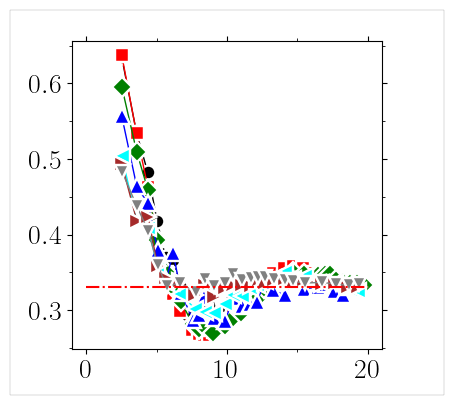

In [31]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    indxx = 0 #--- NiNi
    #--- plot order parameter vs. distance
    symbols=Symbols()
    lg = Legends()
    lg.Set(fontsize=16,
           bbox_to_anchor=(0.5,0.4,0.5,0.5),
          )
    ax = utl.PltErr(None,None,Plot=False)
                

    #--- loop over temp
    Temps  = {
            0:300,
            1:400,
            2:500,
            3:600,
            4:700,
            5:800,
            6:900,
#             7:1000,
        }
    keys = list(Temps.keys())
    keys.sort()
    cutoff=20.0
    ppath = 'nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark'
    stdd = np.zeros(len(Temps))
    for key, count in zip(keys,range(len(keys))): #--- T
        temp = Temps[key]
        pathh = '%s/temp%s/Run0/orderParameter/pr_annealed_ij_index%s.txt'%(ppath,key,indxx)
        print('parse from %s'%pathh)
        try:
            sarray = np.loadtxt(pathh)
            #--- filter
            filtr = ~np.isnan(sarray[:,1])
            #--- order parameter
            sdata = sarray[filtr]
            xdata = sdata[:,0]
            ydata = sdata[:,1]
            #--- std y
#            stdd[count] = np.std( ydata )
            #--- plot
            utl.PltErr(xdata,ydata,#/stdd[count],
                        Plot=False,
                        attrs=symbols.GetAttrs(count=count%7),#,label=r'%s'%temp),      
                        ax=ax,
                        )
        
    
            #--- first dip
#            x_axis, f, valleys = GetExtrema(xdata,ydata,2.3,verbose=False)
#            ksi[count] = valleys[1]
#            print('minimum at ',valleys[1])
        except:
            traceback.print_exc()
            continue
            
    #--- plot
    utl.PltErr([0,cutoff],[0.33,0.33],
                attrs={'fmt':'-.r'},
                ax=ax,
                Plot=False,
                title='orderParameter/wc_diff_sheng_index%s_dpa.png'%indxx,
#               legend=lg.Get(),
#               xlim=[2.0,20.0],
#                  ylim=[0.1-0.33,.7-0.33],
            DrawFrame=[0.2,0.2,0.15,0.1,0.1],
            )


    #--- plot rms
#     utl.PltErr(temps,stdd,
#             Plot=False,
#             attrs=symbols.GetAttrs(),      
#             DrawFrame=[0.2,0.2,0.15,0.1,0.1],
#             yscale='log',
# #            ylim=(0.01,0.1),
#                  title='orderParameter/rms_sro_temperature_pair%s.png'%indxx,
#             )

#### multiple Temperature: rms

In [249]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- plot order parameter vs. distance
    symbols=Symbols()
    lg = Legends()
    lg.Set(fontsize=16,
           bbox_to_anchor=(0.5,0.4,0.5,0.5),
          )
    ax = utl.PltErr(None,None,Plot=False)
                
    for indxx in range(6):

    #--- loop over temp
        temps = [400,600,800,1000,1200,1400]
        stdd = np.zeros(len(temps))
        for temp, count in zip(temps,range(10)): #--- T
            pathh = './NiCoCrNatom100KTemp%ssro/Run0/orderParameter/deltap_r_ij_index%s.txt'%(temp,indxx)
            print('parse from %s'%pathh)
            try:
                sarray = np.loadtxt(pathh)
                #--- filter
                filtr = ~np.isnan(sarray[:,1])
                #--- order parameter
                sdata = sarray[filtr]
                xdata = sdata[:,0]
                ydata = sdata[:,1]
                #--- std y
                stdd[count] = np.std( ydata )
#                 #--- plot
#                 utl.PltErr(xdata,ydata,
#                             Plot=False,
#                             attrs=symbols.GetAttrs(count=count,label=r'$%s$'%temp),      
#                             ax=ax,
#                             )


                #--- first dip
    #            x_axis, f, valleys = GetExtrema(xdata,ydata,2.3,verbose=False)
    #            ksi[count] = valleys[1]
    #            print('minimum at ',valleys[1])
            except:
                traceback.print_exc()
                continue

        #--- plot
#         utl.PltErr([0,cutoff],[0,0],
#                     attrs={'fmt':'-.r'},
#                     ax=ax,
#                     Plot=False,
#                     title='orderParameter/wc_diff_sheng_index%s.png'%indxx,
#                    legend=lg.Get(),
#     #               xlim=[2.0,20.0],
#     #                  ylim=[0.1-0.33,.7-0.33],
#                 DrawFrame=[0.2,0.2,0.15,0.1,0.1],
#                 )


    #--- plot rms
        utl.PltErr(temps,stdd,
                Plot=False,
                attrs=symbols.GetAttrs(count=indxx),      
#                 DrawFrame=[0.2,0.2,0.15,0.1,0.1],
                yscale='log',
                ylim=(0.01,0.1),
                ax=ax
#                      title='orderParameter/rms_sro_temperature_pair%s.png'%indxx,
                )

### atom-wise WC

In [250]:
def Wrapper(itime,pairj,**kwargs):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]

#    pdb.set_trace()
    
    rdf = lp.ComputeRdf(  atoms, box )
    sro = rdf.AtomWiseSro(neigh,pairj)
    
    #--- add xyz
    df = lmpData.coord_atoms_broken[itime]
    df = utl.FilterDataFrame(df, key='id', val=list(sro.id))
    sro_mod = pd.DataFrame(np.c_[df['id type x y z'.split()],sro['1 2 3'.split()]],\
                        columns='id type x y z p1 p2 p3'.split())
#    sro_mod['id']=sro_mod['id'].astype(int)
#    sro_mod['type']=sro_mod['type'].astype(int)

    #--- print
    if 'fout' in kwargs:
        atoms = lp.Atoms( **sro_mod.to_dict(orient='series') )
        wd = lp.WriteDumpFile(atoms, box)
        wd.Write(kwargs['fout'], 
                 itime=itime, 
                 attrs='id type x y z p1 p2 p3'.split(),
                fmt = '%i %i %4.3e %4.3e %4.3e %3.2f %3.2f %3.2f'
                )

    return sro_mod

if eval(confParser['flags']['SroParameter']):
    keys = list(lmpNeigh.coord_atoms_broken.keys())
    keys.sort()
    itime=keys[-1]
    itime0=keys[0]
    #---
    !rm orderParameter/sroPerAtom.xyz
    fp = open('orderParameter/sroPerAtom.xyz','a')
    sro_per_atom0 = Wrapper(itime0,[1,2,3],fout=fp) #--- rss
    sro_per_atom  = Wrapper(itime,[1,2,3],fout=fp) #--- sro
    fp.close()    
        
    #--- output
    


# Dislocations
## load line coordinates

In [251]:
def shift(atomm,lx):
    xc=atomm.x[0]
    atomm.x -= xc
    negative_shift = atomm.x >= 0.5*lx
    positive_shift = atomm.x < -0.5*lx
    assert not np.all([np.any(negative_shift),np.any(positive_shift)])
    atomm.x -= negative_shift * lx
    atomm.x += positive_shift * lx
    atomm.x += xc
    return np.any(negative_shift), np.any(positive_shift)
        
def GetVertexCoords(pathh,box,times,verbose=False):
    atomss = {}
    lx = box.CellVector[ 0, 0 ]
    filtrd_list = os.listdir(pathh) #fnmatch.filter(os.listdir(pathh), 'mydislocations.???')
    if verbose:
        print('files:',filtrd_list)
    for myfile in filtrd_list: #--- multiple files
        #--- time step
        indd=myfile.find('.')
        timei=int(myfile[indd+1:])
        if verbose:
            print('file=',myfile)
            print('timei=',times[timei])
 
        #--- read file
        strr=open('%s/%s'%(pathh,myfile)).readlines() #--- read as string
        li = strr.index('DISLOCATIONS 2\n') #--- 1st line to be read
        if verbose:
            print('read line %s '%li)
        li += 1
        
        atomss[times[timei]] = {}
        tmp = {}
        for ii in range(2): #--- two dislocations
            dislocation_id = int(strr[li])
            if verbose:
                print('dislocation_id=',dislocation_id)
            #
            li += 3
            n_vertices = int(strr[li]) #--- # of lines
            if verbose:
                print('n_vertices=',n_vertices)
            #
            li+=1
            vertice_xyz=np.c_[list(map(lambda x: x.rsplit(sep=' ')[:3],strr[li:li+n_vertices]))].astype(float)
            li+=n_vertices
            #--- wrap
            tmp[ii]=lp.Atoms(x=vertice_xyz[:,0],
                                             y=vertice_xyz[:,1],
                                             z=vertice_xyz[:,2]
            )
            wrap = lp.Wrap(tmp[ii],box)
            wrap.WrapCoord()
            wrap.Set( tmp[ii] )
            wrap = lp.Wrap(tmp[ii],box)
            assert np.all(wrap.isInside()), 'aotms outside original box!'    
        #--- shift      
#        xmean0=np.mean(tmp[0].x)
        negative_shift, positive_shift = shift(tmp[0],lx)
#        if negative_shift or positive_shift:
#           print('shift',np.mean(tmp[0].x),xmean0,times[timei])

#        xmean1=np.mean(tmp[1].x)
        negative_shift, positive_shift = shift(tmp[1],lx)
#        if negative_shift or positive_shift:
#           print('shift',np.mean(tmp[1].x),xmean1,times[timei])

        #--- shift disl.0 or disl.1
        if np.mean(tmp[1].x)-np.mean(tmp[0].x) < -0.5*lx:
            tmp[1].x += lx
        elif np.mean(tmp[1].x)-np.mean(tmp[0].x) > 0.5*lx:
            tmp[1].x -= lx

        #--- front:0 rear: 1
        front = 1
        behind = 0
        if np.mean(tmp[0].x) - np.mean(tmp[1].x) > 0.0:
            front = 0
            behind = 1
        tmp_front = tmp[front]
        tmp_behind = tmp[behind]

        tmp[0] = tmp_front
        tmp[1] = tmp_behind
                    
        atomss[times[timei]][0] = tmp[0]
        atomss[times[timei]][1] = tmp[1]
#        counter += 1
            
    return atomss

if eval(confParser['flags']['DislocAnl']):
    path = confParser['input files']['path']
    indx = confParser['input files']['fileIndex']
    fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
    nevery = int(confParser['parameters']['nevery'])
    #--- make directory
    if eval(confParser['dislocation analysis']['WritDisc']) and not eval(confParser['dislocation analysis']['ReadDisc']):
        try:
            os.system('rm -r dislocations')
        except:
            pass
        !mkdir -p dislocations/mydislocations
        #--- run ovitos
        #
        !ovitos OvitosCna.py $fileName mydislocations $nevery 5
        !mv mydislocations.* dislocations/mydislocations

    #--- box
    box = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) )

    #--- load ca files: extract xyz
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    atomss = GetVertexCoords('./dislocations/mydislocations', box, times, verbose=False) #--- dislocation segments
    print(atomss.keys())
    
    #--- print
    timei=0
    idd=1 #--- dislocation id
    display(pd.DataFrame(atomss[timei][idd].__dict__))


## 3d map

In [252]:
# from mpl_toolkits import mplot3d

# for ii in atomss.keys():
#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     xyz_data=np.c_[atomss[ii].x, atomss[ii].y, atomss[ii].z ]
    
#     zlo=xyz_data[:,2].min()
#     zhi=xyz_data[:,2].max()
#     dz=zhi-zlo
#     ymean=xyz_data[:,1].mean()
#     xmean=xyz_data[:,0].mean()

#     ax.set_zlim(zlo,zhi)
#     ax.set_ylim(ymean-0.5*dz,ymean+0.5*dz)
#     ax.set_xlim(xmean-0.5*dz,xmean+0.5*dz)


#     ax.plot3D(xyz_data[:,0],xyz_data[:,1],xyz_data[:,2] , 'black')
#     plt.show()

## sro within stacking fault

In [253]:
class PltDislAtoms:
    '''
    Plot dislocation line on top of atoms
    '''
    def __init__(self, df, box, Plot=False, **kwargs ):
        self.atoms = df
        self.box = box
        self.plot = Plot
        self.ax = utl.PltErr(None,None,Plot=False,**kwargs)
        #--- axis limits
        self.ymean = []
        self.xlo=[]
        self.xhi=[]
        self.zlo=[]
        self.zhi=[]
                       
    def IntrpDisLines(self,dislc):
        '''
        interpolate line segments onto a grid
        '''
        self.zint, self.xint, junk = interp(dislc,self.box,0,Plot=False)

    def Copy(self,atoms):
        return lp.Atoms(x=np.copy(atoms.x),
                       y=np.copy(atoms.y),
                       z=np.copy(atoms.z))
        
    def Wrap(self,dislc):
        '''
        wrap line segments
        '''
        wrap = lp.Wrap(dislc,self.box)
        wrap.WrapCoord()
        wrap.Set( dislc )
        wrap = lp.Wrap(dislc,self.box)
        assert np.all(wrap.isInside()), 'aotms outside original box!'
        
    def PlotLines(self,df_dislc,**kwargs):
        '''
        plot segments (and arrows)
        '''
        dislc = self.Copy(df_dislc)
        self.Wrap(dislc)
        self.IntrpDisLines(dislc)
        
        if not self.plot:
            plt.ioff()
            
        #--- set axis limits
        self.ymean += [np.mean(dislc['y'])]
        self.xlo += [np.min(self.xint)]
        self.xhi += [np.max(self.xint)]
        self.zlo += [np.min(self.zint)]
        self.zhi += [np.max(self.zint)]
        
        #--- lines
        self.ax=utl.PltErr(self.xint, 
                       self.zint,
                       attrs={'fmt':'-','lw':2,'color':'black'},
                       Plot=False,
                       ax = self.ax
                      )

        #--- plot arrows (velocity)
        if 'dx' in kwargs and 'dy' in kwargs: 
            dx = kwargs['dx']
            assert len(self.xint) == len(dx), 'len(self.xint)=%s,len(dx)=%s'%(len(self.xint),len(dx))
            dx -= np.mean(dx)
            dx /= np.std(dx)
            list(map(lambda x: self.ax.arrow(self.xint[x], self.zint[x],
                                        dx=8*dx[x],dy=kwargs['dy'][x],
                                        head_width=5,
                                        head_length=6,
                                        lw=0.6,
                                        color='black',#'C0',
                                       ),range(0,len(self.xint),6)))


    def PlotAtoms(self,s=8,alpha=0.5,**kwargs):
        #--- xyz
        x=self.atoms['x']
        y=self.atoms['y']
        z=self.atoms['z']
        ttype=np.array(self.atoms['type'],dtype=str)
        ttype[ttype=='1']='#D2E3E6'
        ttype[ttype=='2']='#404EB1'
        ttype[ttype=='3']='#B44A43'
        attrs={}
        if 'stress' in kwargs:
            ttype = kwargs['stress']
            attrs={'cmap':'seismic'}
#            print(ttype)
        
        #--- 2d stack
        ymean = np.mean(self.ymean) if not 'ystack' in kwargs else kwargs['ystack']
        rc = 1.0 if not 'rc' in kwargs else kwargs['rc']
        filtr = np.all([ymean-rc<=y, y<ymean+rc],axis=0)

        #--- axis limits
        self.xlim=kwargs['xlim'] if 'xlim' in kwargs else\
                  (np.min(self.xlo),np.max(self.xhi) )
        self.ylim=kwargs['ylim'] if 'ylim' in kwargs else\
                  (np.min(self.zlo),np.max(self.zhi) )


        #--- plot atoms
        self.ax.scatter( x[filtr],z[filtr], 
                   c=ttype[filtr],
                   s=s,
                   alpha=alpha,
                   **attrs, #cmap="seismic",
                )

    def Save(self,title,**kwargs):
        #
        utl.PltErr( None,None, attrs={'fmt':'.','markersize':2},
                xlim=self.xlim,
                ylim=self.ylim,
               ax=self.ax,
               title=title,
               Plot = False,
                   **kwargs
                )
        #
        if not self.plot:
            plt.close(self.ax.get_figure())

In [254]:
class SroStackFault(PltDislAtoms):
    '''
    compute sro parameters within a stacking ault
    '''
    def __init__(self, df, box ):
        PltDislAtoms.__init__(self,df,box,Plot=False)

        
    def SetLimits(self,df_dislc,**kwargs):
        '''
        set xyz limits
        '''
        dislc = self.Copy(df_dislc)
        self.Wrap(dislc)
        self.IntrpDisLines(dislc)
        
            
        #--- set axis limits
        self.ymean += [np.mean(dislc['y'])] if not 'ystack' in kwargs else [kwargs['ystack']]
        self.xlo += [np.min(self.xint)]
        self.xhi += [np.max(self.xint)]
        self.zlo += [np.min(self.zint)]
        self.zhi += [np.max(self.zint)]
        
    def SetFiltr(self, rc = 2.5):
        #--- limits
        xxlo = np.min(self.xlo)
        xxhi = np.max(self.xhi)
        zzlo = np.min(self.zlo)
        zzhi = np.max(self.zhi)
        yylo = np.min(self.ymean)-rc
        yyhi = np.max(self.ymean)+rc

        #--- xyz
        x=self.atoms['x']
        y=self.atoms['y']
        z=self.atoms['z']
    
        self.filtr = np.all([y>=yylo, y<yyhi, x>=xxlo, x<xxhi, z>=zzlo, z<zzhi ],axis=0)



        
    
    def GetNeighborList(self,confParser):
        
        #--- set parameters
        natoms = eval(confParser['neigh list']['natom']) #--- subset of atoms
        self.cutoff = eval(confParser['neigh list']['cutoff'])
        nevery = 1 #int(confParser['parameters']['nevery'])
        
        #--- write dump file
        fileName = 'dislocations/dump.xyz'
        wd = lpp.WriteDumpFile(lp.Atoms(**self.atoms.to_dict()), self.box)
        wd.Write(fileName, itime=0,
                 attrs=['id', 'type', 'x', 'y', 'z' ], 
                 fmt = '%i %i %5.4e %5.4e %5.4e' )
        
        
        #--- filter
        NATOM = len(self.atoms['x'])
        atom_indices = np.arange(NATOM)[self.filtr]
        if natoms < len(atom_indices):
            atom_indices = atom_indices[0:natoms]
#            print(atom_indices)
        atom_indices = ' '.join(list(map(str,atom_indices)))
    
    
        #--- call ovito
        t0=time.time()
        output = 'dislocations/neighList.xyz'
        try:
            !rm $output
        except:
            pass
        #--- build full neigh list but with a list of query points
        !ovitos OvitosCna.py $fileName $output  $nevery 6 $self.cutoff $atom_indices
        print('output neighbor list=%s s'%(time.time()-t0))
        
        #--- parse
        t0=time.time()
        lmpNeigh = lp.ReadDumpFile( 'dislocations/neighList.xyz' )
        lmpNeigh.GetCords( ncount = sys.maxsize)
        print('load neighbor list=%s s'%(time.time()-t0))
        self.neigh = lmpNeigh.coord_atoms_broken[0]
    
    
    def grValleys(self,rmin=2.3):

        rdf = lp.ComputeRdf(  lp.Atoms(**self.atoms.to_dict()), self.box )
        rdf.PairCrltn(  
                      bins=np.arange(0.0,self.cutoff,0.1), 
                      rlist=self.neigh.DIST,
                      regular_r = True,
                      )
        bin_edges1, hist1, err1  = rdf.Get()
        x_axis, f, self.valleys = GetExtrema(bin_edges1,hist1,rmin)
    
    
    def SetSro(self,pairi,pairj):
        self.grValleys() #--- valleys
        
        rdf = lp.ComputeRdf(  lp.Atoms(**self.atoms.to_dict()), self.box )
        self.sro = rdf.Sro(self.neigh,pairi,pairj,bins=self.valleys)

        
if eval(confParser['flags']['DislocAnl']):
    #--- timestep
    times = list(atomss.keys())
    times.sort()
    timei = times[-1]

    #--- stacking fault
    sroStack = SroStackFault( df=lmpData.coord_atoms_broken[ timei ], 
                        box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 

                      )

    sroStack.SetLimits(atomss[ timei ][ 0 ])#,ystack=10 )
    sroStack.SetLimits(atomss[ timei ][ 1 ])#,ystack=10)
    sroStack.SetFiltr()
    sroStack.GetNeighborList(confParser)
    sroStack.SetSro(1,1) #--- rss

    bin_edges, p0, dp0 =  sroStack.sro
    PltErr(bin_edges,p0)    

    np.savetxt('dislocations/pr_aging_ij_index%s.txt'%0,
           np.c_[bin_edges,p0,dp0],
           header='r\tp\terr_p')

    
    #--- outside
    sroStack = SroStackFault( df=lmpData.coord_atoms_broken[ timei ], 
                        box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 

                      )

    sroStack.SetLimits(atomss[ timei ][ 0 ], ystack=10 )
    sroStack.SetLimits(atomss[ timei ][ 1 ], ystack=10 )
    sroStack.SetFiltr()
    sroStack.GetNeighborList(confParser)
    sroStack.SetSro(1,1) #--- rss

    bin_edges, p0, dp0 =  sroStack.sro
    PltErr(bin_edges,p0)    

    np.savetxt('dislocations/pr_aging_ij_index%s_ystack10.txt'%0,
           np.c_[bin_edges,p0,dp0],
           header='r\tp\terr_p')

    

                



In [255]:
# box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) )
# box.BoxBounds[1][:2].astype(float)
# sroStack.ymean

### Plot

In [256]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    indxx = 0 #--- NiNi
    #--- plot order parameter vs. distance
    symbols=Symbols()
    lg = Legends()
    lg.Set(fontsize=16,
           bbox_to_anchor=(0.5,0.4,0.5,0.5),
          )
    ax = utl.PltErr(None,None,Plot=False)
    
    #--- loop over temp
    temp = 600
    for count, label in zip(range(3),['Total','Sacking fault',r'$y=10 \r{A}$']): #--- T
        pathh = [
#            './NiCoCrNatom100KTemp%ssro/Run0/orderParameter/pr_annealed_ij_index%s.txt'%(temp,indxx),
#            './NiCoCrNatom100KTemp600AgingSro/Run0/dislocations/pr_aging_ij_index%s.txt'%(indxx),
            'orderParameter/pr_annealed_ij_index%s.txt'%(indxx), #--- total
            'dislocations/pr_aging_ij_index%s.txt'%(indxx), #--- y=y(dislocation)
            'dislocations/pr_aging_ij_index%s_ystack10.txt'%(indxx), #--- y=10
            
                ][count]
        print('parse from %s'%pathh)
        try:
            sarray = np.loadtxt(pathh)
            #--- filter
            filtr = ~np.isnan(sarray[:,1])
            #--- order parameter
            sdata = sarray[filtr]
            xdata = sdata[:,0]
            ydata = sdata[:,1]
            #--- plot
            utl.PltErr(xdata,ydata,
                        Plot=False,
                        attrs=symbols.GetAttrs(count=count,label=label),      
                        ax=ax,
                        )
        
    
            #--- first dip
#            x_axis, f, valleys = GetExtrema(xdata,ydata,2.3,verbose=False)
#            ksi[count] = valleys[1]
#            print('minimum at ',valleys[1])
        except:
            traceback.print_exc()
            continue
            
    #--- plot
    utl.PltErr([0,20],[0.33,0.33],
                attrs={'fmt':'-.r'},
                ax=ax,
                Plot=False,
                title='orderParameter/wc_aging_dislocated_index%s.png'%indxx,
               legend=lg.Get(),
#               xlim=[2.0,20.0],
#                  ylim=[0.1-0.33,.7-0.33],
            DrawFrame=[0.2,0.2,0.15,0.1,0.1],
            )

## height correlations

In [257]:
def interp(df,box,timei,verbose=False,Plot=True,**kwargs):
    x=df.z
    y=df.x
    #
    [xlo, xhi, junk]=box.BoxBounds[2].astype(float)
#    print(xlo,xhi)
    dx=1.0 #2*np.ceil(np.abs(np.diff(x)).min())
    hist, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx))
    ysum, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx),weights=y)
    ysum2, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx),weights=y*y)
    ymean = ysum / hist
    ysum2 /= hist
    ysum2 -= ymean*ymean
    ystd = (ysum2 / hist)**0.5
    bin_edges = (bin_edges[1:]+bin_edges[:-1])*0.5
    
    if Plot:
        if verbose:
            print('itime=',timei)
        if 'ax' in kwargs:
            ax = kwargs['ax']
            args = {'ax':ax}
            kwargs.pop('ax')
        else:
            args={}
        xx=0.5*(x.max()-x.min())
        
        ax=PltErr(y,x,
              attrs={'fmt':'.'},
                Plot=False,
                **args
              )
        ax=PltErr(ymean,bin_edges, #yerr=ystd,
              attrs={'fmt':'-r'},
               ax=ax,
#                ylim=(np.mean(y)-xx,np.mean(y)+xx),
#                xlim=(np.min(x),np.max(x)),
                Plot=False,
               **kwargs
              )
    
    return bin_edges, ymean, ystd


def Crltn(x,y):
    xq=np.fft.fft(x)
    yq=np.fft.fft(y)
    return np.fft.ifft(np.abs(xq*yq))/len(xq)

def PltCrltnn(xint,yint, Plot = True, attrs={'fmt':'-'},**kwargs):
#    print(yint.shape)
    crltn = Crltn(zscore(yint),zscore(yint))
    n = xint.shape[0]
#    print(kwargs)
    if Plot:
        PltErr((xint-xint[0])[0:int(n/2+n%2)],crltn[0:int(n/2+n%2)],
               attrs=attrs,
               Plot = False,
               **kwargs)
    return (xint-xint[0])[0:int(n/2+n%2)],crltn[0:int(n/2+n%2)] #, xint[crltn<0][0]
        
if eval(confParser['flags']['DislocAnl']):

    zscore = lambda x: (x-np.mean(x))/np.std(x) 


    #--- interpolate h(z)
    times = list(atomss.keys())
    times.sort()
    timei=times[-1]
    xint, yint, junk = interp(atomss[timei][idd],box,timei,
                             ystr=r'$z$'    if not eval(confParser['flags']['RemoteMachine']) else 'z',
                             xstr=r'$h(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'h(z)' ,
                             )

    #--- correlation
    junk,  junk =PltCrltnn(xint,yint,
                                xstr=r'$|z-z^\prime|$' if not eval(confParser['flags']['RemoteMachine']) else 'dz',
                               ystr=r'$\langle h(z)h(z^\prime)\rangle$' if not eval(confParser['flags']['RemoteMachine']) else 'c(dz)',

                 )


### plot

In [258]:

            
            
            

if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):

    #--- timestep
    times = list(atomss.keys())
    times.sort()
    timei = times[-1]
    
    #--- box
    box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) )
    aspect_ratio = box.CellVector[0,0]/box.CellVector[2,2]
    
    
    #--- plot
    pltDisl = PltDislAtoms( df=lmpData.coord_atoms_broken[ timei ], 
                           box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
                           Plot = True, 
                           figsize=(4*aspect_ratio,4) 
                          )
    #--- plot lines
    pltDisl.PlotLines(atomss[ timei ][ 0 ],
#                     dx = vel[0], #--- velocities
#                     dy = np.zeros(len(vel[0])),

                    )
    pltDisl.PlotLines(atomss[ timei ][ 1 ])
    #--- plot atoms
    pltDisl.PlotAtoms(s=10,
                      alpha=0.5,#.8,#.4,
#                     xlim=(np.mean(df_disc0.x)-0.5*(np.max(df_disc0.z)-np.min(df_disc0.z)),
#                           np.mean(df_disc0.x)+0.5*(np.max(df_disc0.z)-np.min(df_disc0.z))),
    #                 xlim = (0,760),
                       xlim=box.BoxBounds[0][:2].astype(float),
                       ylim=box.BoxBounds[2][:2].astype(float),
#                       ystack = 10.0, #np.mean(box.BoxBounds[1][:2].astype(float)), #--- comment if there are dislocations
                        rc=2.5,
                     )
    #--- save
    pltDisl.Save(
                 title='dislocations/DislAgedT600K',
#                 title='dislocations/DislAgingT600K.png',
#                 title='dislocations/DislRandomT600K.png',
                 dpi=150,
                DrawFrame=[0.035,0.035,0.15,0.1,0.1],
                )


In [259]:
#print('every ang is', 3.0/box.CellVector[2,2])

In [260]:
scalee=0.02270484123882844
lx=100 #A

if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    figsize=lx*scalee

    #--- timestep
    times = list(atomss.keys())
    times.sort()
    timei = times[-1]
    
    #--- box
    box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) )
    aspect_ratio = box.CellVector[0,0]/box.CellVector[2,2]
    
    
    #--- plot
    pltDisl = PltDislAtoms( df=lmpData.coord_atoms_broken[ timei ], 
                           box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
                           Plot = True, 
                           figsize=(figsize,figsize) 
                          )

    #--- plot atoms
    pltDisl.PlotAtoms(s=4,
                      alpha=0.5,#.8,#.4,
#                     xlim=(np.mean(df_disc0.x)-0.5*(np.max(df_disc0.z)-np.min(df_disc0.z)),
#                           np.mean(df_disc0.x)+0.5*(np.max(df_disc0.z)-np.min(df_disc0.z))),
    #                 xlim = (0,760),
                      xlim=(float(box.BoxBounds[0][0]),float(box.BoxBounds[0][0])+lx),
                      ylim=(float(box.BoxBounds[2][0]),float(box.BoxBounds[2][0])+lx),
                      ystack = np.mean(box.BoxBounds[1][:2].astype(float)), #--- comment if there are dislocations
                        rc=2.5,
                     )
    #--- save
    pltDisl.Save(
                 title='dislocations/sroDislFree.png',
#                 title='dislocations/DislAgingT600K.png',
#                 title='dislocations/DislRandomT600K.png',
                 dpi=150,
                DrawFrame=[0.2,0.1,0.15,0.1,0.1],
                )


In [261]:
def PltDislAtomsWrapperFunc(**kwargs):
    #--- plot
    pltDisl = PltDislAtoms( df=kwargs['df'],#lmpData.coord_atoms_broken[ timei ], 
                           box=kwargs['box'],#lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
                           Plot = kwargs['Plot'],#True, 
    #                       figsize=(18,3) 
                          )
    #--- plot lines
    args = {}
    if 'dx' in kwargs and 'dy' in kwargs:
        args={'dx':kwargs['dx'],'dy':kwargs['dy']}
    pltDisl.PlotLines(kwargs['df_disc'],#atomss[ timei ][ 0 ],
                      **args,
#                      dx = vel[0], #--- velocities
#                      dy = np.zeros(len(vel[0])),

                     )
    #pltDisl.PlotLines(df_disc1)
    attrs = {} if not 'stress' in kwargs else {'stress':kwargs['stress']}
    #--- plot atoms
    pltDisl.PlotAtoms(s=10,
                      alpha=.8,#.4,
                     xlim=(np.mean(kwargs['df_disc'].x)-0.5*(np.max(kwargs['df_disc'].z)-np.min(kwargs['df_disc'].z)),
                           np.mean(kwargs['df_disc'].x)+0.5*(np.max(kwargs['df_disc'].z)-np.min(kwargs['df_disc'].z))),
    #                 xlim = (0,760),
                      **attrs
                     )
    #--- save
    pltDisl.Save(
                 title=kwargs['title'],#'dislocations/DislVelocItime%s_id%s.png'%(timei,idd),
                 dpi=kwargs['dpi'],#150,
                DrawFrame=kwargs['DrawFrame'],#[0.2,0.1,0.15,0.1,0.01],
                )

if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    PltDislAtomsWrapperFunc(
        df=lmpData.coord_atoms_broken[ timei ], 
        box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
        Plot = True,
        df_disc=atomss[ timei ][ 0 ],
        title='dislocations/DislVelocItime%s_id%s.png'%(timei,idd),
        dpi=150,
        DrawFrame=[0.2,0.1,0.15,0.1,0.01],
    )


### multiple timesteps

In [262]:
if eval(confParser['flags']['DislocAnl']):
    #--- timestep
    times = list(atomss.keys())
    times.sort()
    timei = times[0]
    
    #--- discretized x
    xint, junk, junk = interp(atomss[timei][idd],box,timei,Plot=False)

    for idd in [0,1]:
        #--- interpolate
        ax = PltErr(None,None,Plot=False)
        yint = np.c_[list(map(lambda x:interp(atomss[x][idd],box,x,Plot=True,ax=ax,                             
                                              ystr=r'$z$' if not eval(confParser['flags']['RemoteMachine']) else 'z',
                                              xstr=r'$h(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'h(z)',
                                              xlim=(0,761)
                                             )[1],times))]
        plt.show()
        #--- print
        header = 'r\t'+reduce(lambda x,y:x+y,map(lambda x: 'h_%s\t'%x ,range(yint.shape[0])))
        np.savetxt('dislocations/h%s_profile_multiple_times.txt'%idd,np.c_[xint,yint.T],header=header)

        #--- plot lines & atoms                
        list(map(lambda x:        
            PltDislAtomsWrapperFunc(
            df=lmpData.coord_atoms_broken[ x ], 
            box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
            Plot = False,
            df_disc=atomss[ x ][ idd ],
            title='dislocations/DislItime%s_id%s.png'%(x,idd),
            dpi=150,
            DrawFrame=[0.2,0.1,0.15,0.1,0.01],
            ),times))

In [263]:
#np.std(yint)

### multiple timesteps: plot h

In [264]:
indxx=1 #--- csa, rsa
dislocation_id = 0


In [265]:
class parse:
    def __init__(self,fp0,fp1):
        self.fp0 = fp0
        self.fp1 = fp1
        pass
    def ParseData(self,load, pathh,dislocation_id,**kwargs):
        print('load=%s'%load)
        sdata0 = np.loadtxt('%s/%s'%(pathh,self.fp0)) #--- velocity profile
        sdata1 = np.loadtxt('%s/%s'%(pathh,self.fp1)) #--- velocity profile

        #--- fetch data
        self.r = sdata0[:,0]
        hx0 = sdata0[:,1:]
        hx1 = sdata1[:,1:]
        hx=[hx0,hx1][dislocation_id]
        if 'index' in kwargs: 
            val=hx.T[kwargs['index']]
        else:
            val = hx.T
        return val
    def Get_r(self):
        return self.r

if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):

    #--- parse data
    loads = [
                [500,600,650,700,750], #--- csa
                [400,500,550,600,650], #--- rsa
              ][indxx]
    
    ps = parse('h0_profile_multiple_times.txt',
               'h1_profile_multiple_times.txt'
              )
    hx = np.array(list(map(lambda x:ps.ParseData(
              load=x,
              pathh=[
                     'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%x,
                     'NiCoCrNatom100KTemp600Rss/dislocated/load%s/Run0/dislocations'%x,
                    ][indxx],
              dislocation_id = dislocation_id,
              index = -1,
                ), loads))).T
    r = ps.Get_r()
    print('hx.shape=',hx.shape)

    
    
    
    #--- plot
    ax0=PltErr(None,None,Plot=False)
    shift = lambda x:(1+x)*50 #--- shift vertically
    attrs = {'markevery':1,'markersize':8}
#     list(map(lambda x:PltErr(x[0]-np.mean(x[0])+shift(x[1]),r,ax=ax0,
#                              attrs={'fmt':'-','label':load,'color':'C0'},
#                              Plot=False,
#                             ylim=(np.min(r),np.max(r)),
#                             xlim=(0,0.4*761),
#                             ),zip(hx.T,range(10))))
    list(map(lambda x:PltErr((x[0]-np.mean(x[0]))/np.std(x[0])+5*(x[1]-2),r,ax=ax0,
                             attrs={'fmt':'-','label':load,'color':'C0'},
                             Plot=False,
                            ylim=(np.min(r),np.max(r)),
                            xlim=(-14,14),
                            ),zip(hx.T,range(10))))
                                 
    utl.PltErr(None,None,ax=ax0,
                DrawFrame=[0.2,0.1,0.15,0.1,0.01],
                title='dislocations/h0_%s.png'%indxx,
      )


In [266]:
#np.mean(np.std(hx,axis=0))

In [267]:
#     #--- parse data
#     load = 1200
#     ps = parse('vx0_profile_multiple_times.txt',
#                'vx1_profile_multiple_times.txt'
#               )
#     for dislocation_id in [0,1]:
#         vx = ps.ParseData(
#                   load=load,
#                   pathh=[
#                          'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load,
#                          'NiCoCrNatom100KTemp600Rss/dislocated/load%s/Run0/dislocations'%load,
#                         ][indxx],
#                   dislocation_id = dislocation_id,
#                     ).T
#         r = ps.Get_r()
#         print('vx.shape=',vx.shape)
#         ntime=vx.shape[1]
#         timei=0#int(ntime/2)
#         timef=ntime



#         #--- plot
#         ax0=PltErr(None,None,Plot=False)
#         shift = lambda x:(1+x)*50 #--- shift vertically
#         attrs = {'markevery':1,'markersize':8}
#         list(map(lambda x:PltErr(x,r,ax=ax0,
#                                  attrs={'fmt':'-','label':load,'color':'C0'},
#                                  Plot=False,
# #                                ylim=(np.min(r),np.max(r)),
# #                                xlim=(-14,14),
#                                 ),vx.T[timei:timei+1]))
                                 


### correlations

In [268]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- plot
    symbols = Symbols()
    legends = Legends()
    legends.Set(fontsize=16,
                labelspacing=.2,
                bbox_to_anchor=[(0.53,0.46,0.5,0.5),(0.3,0.42,0.5,0.5)][indxx]            
               )
    axc=PltErr([0,761],[0,0],attrs={'fmt':'-.r'},Plot=False)

            

    #--- plot correlations
    #--- correlation
    list(map(lambda x:PltCrltnn(r,x[0],
                    Plot=True,
                   ax=axc,
                   attrs=symbols.GetAttrs(count=x[1],label=r'$%s$'%loads[x[1]],nevery=8,fmt='-'),
                        ),
             zip(hx.T,range(10))))
                                             
    utl.PltErr(None,None,ax=axc,
               marker='o',
               DrawFrame=[0.2,0.1,0.15,0.1,0.01],
               ylim=(-1,1),
               xlim=(0,(np.max(r)-np.min(r))/2),
            title='dislocations/h0_crltn_%s.png'%indxx,
           legend=legends.Get(),
              )


## velocity correlations

In [269]:
def minImage(v,box,verbose=False):
    lx = box.CellVector[ 0, 0 ]
    #--- minimum image
    v -= (np.mean(v) >= 0.5*lx) * lx
    v += (np.mean(v) < -0.5*lx) * lx
    return v

if eval(confParser['flags']['DislocAnl']):
    times = list(atomss.keys())
    times.sort()

    for idd in [0,1]:
        #--- interpolate
        ax = PltErr(None,None,Plot=False)
        #--- discretized x
        xint, junk, junk = interp(atomss[timei][idd],box,timei,Plot=False)
        yint = np.c_[list(map(lambda x:interp(atomss[x][idd],box,x,Plot=False,ax=ax,                             
                                             )[1],times))]


        #--- velocity fluctuations
        print('h.shape=',yint.shape)
    #    vel0=np.diff((yint0.T-np.mean(yint0,axis=1)),axis=1).T
        vel=np.diff((yint.T),axis=1).T
        vel=np.c_[list(map(lambda x:minImage(x,box),vel))] #--- pbc
        dt = times[1]-times[0]
        vel /= dt
        #--- print
        header = 'r\t'+reduce(lambda x,y:x+y,map(lambda x: 'vx_%s\t'%x ,range(vel.shape[0])))
        np.savetxt('dislocations/vx%s_profile_multiple_times.txt'%idd,np.c_[xint,vel.T],header=header)
        #
    #    vel0=(vel0.T-np.mean(vel0,axis=1)).T #--- zero mean
    #    vel0=(vel0.T/np.std(vel0,axis=1)).T  #--- unit variance
    #    vel=np.c_[vel.T,1+vel[0,:]].T
        print('v.shape=',vel.shape)

        #--- plot
        ntime=vel.shape[0]
        timei=0
        timef=ntime
        ax=PltErr(None,None,Plot=False)
        list(map(lambda x:PltErr(x,xint,ax=ax,
                                 attrs={'fmt':'-'},
                                 Plot=False,
                                 ystr=r'$z$' if not eval(confParser['flags']['RemoteMachine']) else 'z',
                                 xstr=r'$v_x(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'vx(z)'),
                 vel[timei:timef]))
        plt.show()
    
        #--- plot lines & atoms
#         list(map(lambda x:PltDislAtoms(xint,yint[x[1]],
#                                   lmpData.coord_atoms_broken[ x[0] ],
#                                   atomss[ x[0] ][ idd ],
#                                   box,
#                                   'dislocations/DislVelocItime%s_id%s.png'%(x[0],idd),
#                                  dx = vel[x[1]],
#                                  dy = np.zeros(len(yint[x[1]])),
#                                     Plot=False,
#                                       ),
#                  zip(times,range(ntime))))


        list(map(lambda x:        
            PltDislAtomsWrapperFunc(
            df=lmpData.coord_atoms_broken[ x[0] ], 
            box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
            dx = vel[x[1]],
            dy = np.zeros(len(vel[x[1]])),
            Plot = False,
            df_disc=atomss[ x[0] ][ idd ],
            title='dislocations/DislVelocItime%s_id%s.png'%(x[0],idd),
            dpi=150,
            DrawFrame=[0.2,0.1,0.15,0.1,0.01],
            ),zip(times,range(ntime))))

In [270]:
# def vonMises(df):
#     return np.array(list(np.sqrt(0.5*((df.sxx-df.syy)**2+(df.syy-df.szz)**2+(df.szz-df.sxx)**2)+3*(df.sxy**2+df.syz**2+df.sxz**2))))

# #--- plot stress
# indx=8 #7 #6 #4
# itime=times[indx]
# idd = 1
# #
# PltDislAtomsWrapperFunc(
# df=lmpData.coord_atoms_broken[ itime ], 
# box=lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) ), 
# dx = vel[indx],
# dy = np.zeros(len(vel[indx])),
# Plot = True,
# df_disc=atomss[ itime ][ idd ],
# title='dislocations/DislStressItime%s_id%s.png'%(itime,idd),
# dpi=150,
# DrawFrame=[0.2,0.1,0.15,0.1,0.01],
# stress = vonMises(lmpData.coord_atoms_broken[ itime ]),
# )
        



### multiple timesteps

### Plot
#### mean velocity

In [271]:
indxx=0 #--- csa, rss
dislocation_id = 1


In [272]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):

    loads= [
                        [1300,1200,1100,1000,950,750,700,650,600,500], #--- csa
                        [1200,1100,900,800,750,700,650,600,550,500,400], #--- rsa

][indxx]

    #--- parse
    ps = parse('vx0_profile_multiple_times.txt',
               'vx1_profile_multiple_times.txt'
              )
    vx = np.array(list(map(lambda x:ps.ParseData(
              load=x,
              pathh=[
                     'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%x,
                     'NiCoCrNatom100KTemp600Rss/dislocated/load%s/Run0/dislocations'%x,
                    ][indxx],
              dislocation_id = dislocation_id,
                ), loads))).T
    r = ps.Get_r()
    print('vx.shape=',vx.shape)

    
    
    
    #--- plot
    ax=PltErr(None,None,Plot=False)
    list(map(lambda x:PltErr(np.arange(x.shape[1]),np.abs(np.mean(x,axis=0)),
                   ax=ax,
                    attrs={'fmt':'.','markersize':12},
                    xstr=r'itime',
                    ystr=r'$\langle v_x \rangle$',
                    yscale='log',
                    ylim=(1e-8,1e4),
                   Plot=False,
                    ), vx))
        
    #--- average
    vx_mean=list(map(lambda x:10**np.mean(np.log10(np.abs(x))),vx)) #--- mean velocity


In [273]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    prefact = 1e-10/(0.004*0.001*1e-9)
    np.savetxt('dislocations/mobility_%s.txt'%indxx,np.c_[loads,prefact*np.array(vx_mean)])
    PltErr(loads,prefact*np.array(vx_mean),
#           yscale='log',
       DrawFrame=[0.2,0.1,0.15,0.1,0.01],
        title='dislocations/mobility_%s.png'%indxx,
          )


In [274]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    data0 = np.loadtxt('dislocations/mobility_%s.txt'%0)
    data1 = np.loadtxt('dislocations/mobility_%s.txt'%1)
    symbols=Symbols()
    legends = Legends()
    legends.Set(fontsize=16,labelspacing=.2,
#                bbox_to_anchor=(0.5,0.44,0.5,0.5),
#                bbox_to_anchor=(0.65,0.3,0.5,0.5),
               )

    ax=utl.PltErr(data1[:,0],data1[:,1],Plot=False,
            attrs=symbols.GetAttrs(count=0,label='RSA',fmt='-'),
              )

    utl.PltErr(data0[:,0],data0[:,1],
            attrs=symbols.GetAttrs(count=1,label='annealed',fmt='-'),
              ax=ax,
    #           yscale='log',
           DrawFrame=[0.2,0.1,0.15,0.1,0.01],
            title='dislocations/mobility.png',
        legend=legends.Get(),          
              )


####  velocity profile

In [275]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- parse data
    load = 1200
    ps = parse('vx0_profile_multiple_times.txt',
               'vx1_profile_multiple_times.txt'
              )
    vx = ps.ParseData(
              load=load,
              pathh=[
                     'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load,
                     'NiCoCrNatom100KTemp600Rss/dislocated/load%s/Run0/dislocations'%load,
                    ][indxx],
              dislocation_id = dislocation_id,
#              index = range(10,20),
                ).T
    r = ps.Get_r()
    print('vx.shape=',vx.shape)
    ntime=vx.shape[1]
    timei=int(ntime/2)
    timef=ntime
    
    
    
    #--- plot
    ax0=PltErr(None,None,Plot=False)
    shift = lambda x:(1+x)*50 #--- shift vertically
    attrs = {'markevery':1,'markersize':8}
    list(map(lambda x:PltErr((x[0]-np.mean(x[0]))/np.std(x[0])+5*(x[1]-2),r,ax=ax0,
                             attrs={'fmt':'-','label':load,'color':'C0'},
                             Plot=False,
                            ylim=(np.min(r),np.max(r)),
                            xlim=(-14,14),
                            ),zip(vx.T[timei:timef:3],range(5))))
    list(map(lambda x:PltErr([5*(x-2),5*(x-2)],[np.min(r),np.max(r)],ax=ax0,
                             attrs={'fmt':'-.','color':'C0'},
                             Plot=False,
                            ),range(5)))
                                 
    utl.PltErr(None,None,ax=ax0,
               marker='o',
                DrawFrame=[0.2,0.1,0.15,0.1,0.01],
                title='dislocations/v0_%s.png'%indxx,
      )

####  velocity correlations

In [276]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    xint = r
    
    #--- plot
    legends = Legends()
    legends.Set(fontsize=16,labelspacing=.2)
    
    ax=utl.PltErr([0,(np.max(r)-np.min(r))/2],[0,0],attrs={'fmt':'-.r'},Plot=False)
    
    #--- correlation
    cvx = np.c_[list(map(lambda x:PltCrltnn(xint,x[0],ax=ax,
                           attrs=symbols.GetAttrs(count=x[1],label=r'$(%s)$'%(x[1]+1),nevery=8,fmt='-'),
                                           )[1].real,
             zip(vx.T[timei:timef:3],range(5))))]
    #---save
    utl.PltErr(None,None,ax=ax,
           marker='o',
       DrawFrame=[0.2,0.1,0.15,0.1,0.01],
        title='dislocations/v0_crltn_%s.png'%indxx,
        ylim=(-1,1),
        xlim=(0,(np.max(r)-np.min(r))/2),
        legend=legends.Get(),          
          )
    plt.show()
    



#### multiple loads

In [277]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    count=0
    #--- initialize plot object
    ax=PltErr([0,(np.max(r)-np.min(r))/2],[0,0],attrs={'fmt':'-.r'},Plot=False)
    legends = Legends()
    legends.Set(fontsize=16,labelspacing=.2,
                bbox_to_anchor=(0.5,0.44,0.5,0.5),
#                bbox_to_anchor=(0.65,0.3,0.5,0.5),
               )

        
    for load in [
                        [1300,1200,1100,1000], #--- csa
                        [1200,1100,900,800,750,700], #--- rsa
][indxx]:

        print('load=%s'%load)
        pathh = [
                 'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load, #--- csa
                 'NiCoCrNatom100KTemp600Rss/dislocated/load%s/Run0/dislocations'%load, #--- rsa
                'dislocations'
        ][indxx]
        try:
            sdata0 = np.loadtxt('%s/vx0_profile_multiple_times.txt'%pathh) #--- velocity profile
            sdata1 = np.loadtxt('%s/vx1_profile_multiple_times.txt'%pathh) #--- velocity profile

            #--- fetch data
            r = sdata0[:,0]
            vx0 = sdata0[:,1:]
            vx1 = sdata1[:,1:]

            #--- plot
            ntime=vx1.shape[1]
            timei=int(ntime/2)
            timef=ntime
            
            #--- correlations
            xint = r

            #--- plot

            #--- correlation
            vx = [vx0,vx1][dislocation_id]
            cvx = np.c_[list(map(lambda x:PltCrltnn(xint,x,Plot=False,#ax=ax,
        #                            xstr=r'$|z-z^\prime|$' if not eval(confParser['flags']['RemoteMachine']) else 'dz',
        #                               ystr=r'$\langle v_x(z)v_x(z^\prime)\rangle$' if not eval(confParser['flags']['RemoteMachine']) else 'c(dz)',
                                                   )[1].real,
                     vx.T[timei:timef:1]))]

            #--- plot correlations
            z = PltCrltnn(xint,cvx[0],Plot=False)[0]
#            print('z.shape=',z.shape)
#            print('cvv.shape=',cvx.shape)
            cmean = np.mean(cvx,axis=0)
#            print('cmean.shape=',cmean.shape)
            erry = np.std(cvx,axis=0)/len(cvx)**0.5

            utl.PltErr(z,cmean,yerr=None, Plot=False,
                   ax=ax, #markevery=8,Plot=False,label=r'$%s$'%load,
                           attrs=symbols.GetAttrs(count=count,label=r'$%s$'%load,nevery=8,fmt='-')
                  )

        
            count += 1
        except:
            traceback.print_exc()
            continue
            
# utl.PltErr(None,None,ax=ax,
#        DrawFrame=[0.2,0.1,0.15,0.1,0.01],
#        attrs={'markevery':8},
#         title='dislocations/v0_crltn_%s_multipleLoads.png'%indxx,
#         legend=legends.Get(),          
#                ylim=(-0.5,1),
#         xlim=(0,(np.max(r)-np.min(r))/2),

#       )
# plt.show()

In [278]:
#     z = PltCrltn(xint,cvx[0],Plot=False)[0]
#     print('z.shape=',z.shape)
#     print('cvv.shape=',cvx.shape)
#     cmean = np.mean(cvx,axis=0)
#     print('cmean.shape=',cmean.shape)
#     erry = np.std(cvx,axis=0)/len(cvx)**0.5

#     PltErr(z,cmean,yerr=erry,
#  #            xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
#  #            ystr=r'$\langle v_x(z).v_x(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)'
#           )
#     print('ksi_mean=',z[cmean<0][0])
# #     np.savetxt('dislocations/vxcrltn.txt',np.c_[z,cmean.real,erry.real],header='z\tv_x(z)\terr')
# #     np.savetxt('dislocations/vxlength.txt',np.c_[temperature,z[cmean.real<0][0]],header='temp\tksi')

In [279]:
#     z = PltCrltn(xint,cvx[0],Plot=False)[0]
#     print('z.shape=',z.shape)
#     print('cvv.shape=',cvx.shape)
#     cmean = np.mean(cvx,axis=0)
#     print('cmean.shape=',cmean.shape)
#     erry = np.std(cvx,axis=0)/len(cvx)**0.5

#     PltErr(z,cmean,yerr=erry,
#  #            xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
#  #            ystr=r'$\langle v_x(z).v_x(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)'
#           )
#     print('ksi_mean=',z[cmean<0][0])
# #     np.savetxt('dislocations/vxcrltn.txt',np.c_[z,cmean.real,erry.real],header='z\tv_x(z)\terr')
# #     np.savetxt('dislocations/vxlength.txt',np.c_[temperature,z[cmean.real<0][0]],header='temp\tksi')

In [280]:
# if eval(confParser['flags']['DislocAnl']) and not\
#    eval(confParser['flags']['RemoteMachine']):
#     for load in ['500','600','700','800']: #--- different loads
#         print('load=%s'%load)
#         pathh = 'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load
#         sdata = np.loadtxt('%s/vxcrltn_multiple_times.txt'%pathh)
#         r = sdata[:,0]
#         cvx = sdata[:,1:]

#         #--- correlation
#         ax=PltErr(None,None,Plot=False)
#         list(map(lambda x:PltErr(r,x,ax=ax,
#                                 attrs={'fmt':'-'},
#                                 Plot=False,
#                                 ),
#                  cvx.T))
#         PltErr(ax.axis()[:2],[0,0],ax=ax,
#                Plot=False,
#                 xstr=r'$|z-z^\prime|$',
#                 ystr=r'$\langle v_x(z)v_x(z^\prime)\rangle$',
#                attrs={'fmt':'-.','color':'black','lw':2},
#                title='dislocations/vxcrltn_%s.png'%load
#               )
#         plt.show()

#### lengthscale

In [281]:
# if eval(confParser['flags']['DislocAnl']) and not\
#    eval(confParser['flags']['RemoteMachine']):
#     ksii = {}
#     for load in [500,600,700,800]:
#         print('load=%s'%load)
#         pathh = 'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load
#         sdata = np.loadtxt('%s/vxlength_multiple_times.txt'%pathh)
#         n=len(sdata)

#         ax=PltErr(sdata[:,0],sdata[:,1],
#            attrs={'fmt':'o'},
#            xstr=r'$t$',
#            ystr=r'$\xi$',
#             Plot=False,
#           )

#         ksii[load]=utll.GetQuantile(pd.Series(sdata[:,1]),0.95)

#         PltErr(ax.axis()[:2],[ksii[load],ksii[load]],
#                 attrs={'fmt':'-.r'},
#                Plot=False,
#                ax=ax
#               )
        
#     PltErr(ksii.keys(),list(map(lambda x:ksii[x],ksii.keys())),
# #            attrs={'fmt':'-.r'},
#            marker='o',
#            fmt='.',
#            Plot=True,
#            xstr=r'$\sigma$',
#            ystr=r'$\xi$',
#            title='dislocations/xi.png',
#           )
    
# #RemoteMachine=False

# max shear plane

In [282]:
from numpy import linalg as LA

def GetEig(svect):
    smat=np.array([[svect[0],svect[3],svect[4]],
                   [svect[3],svect[1],svect[5]],
                   [svect[4],svect[5],svect[2]]])
    w, v = LA.eigh(smat)
    smax = 0.5*(w[2]-w[0])
    nvec = v[1]
    return smax

if eval(confParser['flags']['maxshear']):
    pref = 1e-6 #--- pa to gpa
    keys = list(lmpData.coord_atoms_broken.keys())
    keys.sort()


    for itime in keys:
        print('itime=',itime)
        df = lmpData.coord_atoms_broken[itime]
        stress = np.c_[df[['sxx', 'syy', 'szz','sxy', 'sxz', 'syz']]]
        smax = np.array(list(map(lambda x:GetEig(x),stress)))*pref

        df_new = pd.DataFrame(np.c_[df['id type x y z'.split()],smax],columns='id type x y z val'.split())

        atom = lp.Atoms(**df_new.to_dict(orient='series'))
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
        wd = lp.WriteDumpFile(atom, box)
        output = open('dump.xyz','a')
        wd.Write(output,itime=itime,
                 attrs=['id', 'type', 'x', 'y', 'z','val'], 
                 fmt='%i %i %4.3e %4.3e %4.3e %4.3e')
        output.close()

# irradiation

## class Statistics

In [78]:
class Statistics:
    pref = 1e-4 #--- bar to GPA
    def __init__(self,path,verbose=False):

        self.path = path
        self.verbose = verbose
        
        #--- list of files
        self.inputFiles = os.listdir('%s'%(path))
        if self.verbose:
            print('class Statistics constructor call: inputFiles=',np.array(self.inputFiles))
            
            
    def ParseDump(self,fp):
        if self.verbose:
            print('parsing %s/%s:'%(self.path,fp))
        self.lmpData = lp.ReadDumpFile('%s/%s'%(self.path,fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            display(self.lmpData.coord_atoms_broken[keys[0]])
            
    def GetStressDump(self):
        '''
        return stress timeseries from dump file
        '''
        #--- timesteps
        keys = list(self.lmpData.coord_atoms_broken.keys())
        keys.sort()

        #--- virial
        szz = np.array(list(map(lambda x:self.lmpData.coord_atoms_broken[x]['c_mystress[3]'].sum(),keys)))

        #--- volume
        vol = np.array(list(map(lambda x:np.linalg.det(lp.Box(BoxBounds=self.lmpData.BoxBounds[x],
                                                     AddMissing=np.array([0,0,0])).CellVector),
                       keys)))

        ezz = Statistics.Strain(self.lmpData)
        self.dmpStrs=pd.DataFrame(np.c_[keys,ezz,Statistics.pref*szz/vol,szz],
                                  columns=['timestep','strain','szz','virial'])

    
    def ParseTimeSeries(self,fp,
                        max_rows=1000000,
                        skiprows=0,
                        cols=['timestep']):    
        if self.verbose:
            print('parsing %s/%s:'%(self.path,fp))
        self.loadTimeSeries=pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(self.path,fp),max_rows=max_rows,skiprows=skiprows)],
                        columns=cols,
                                   )
        self.loadTimeSeriesOriginal = self.loadTimeSeries.copy()
        #--- add timesteps: thermo.txt must include every timestep!
#         n=loadTimeSeries.shape[0]
#         self.loadTimeSeries=pd.DataFrame(np.c_[range(n),loadTimeSeries],
#                                          columns = ['timestep']+list(loadTimeSeries.keys()))
        
    def PltTimeSeries(self,ld, xdata='strain',ydata='szz',
                      **kwargs):

        #--- set limits

        #--- time
        tlo = ld[xdata].min() if not 'xlim' in kwargs else kwargs['xlim'][0]
        thi = ld[xdata].max() if not 'xlim' in kwargs else kwargs['xlim'][1] #ld.Time.max()
        filtr=np.all([ld[xdata]<thi,ld[xdata]>=tlo],axis=0)
#         # #--- load
        flo = 0.99*ld[ydata][filtr].min()
        fhi = 1.01*ld[ydata][filtr].max() 

        #--- rate
        rate = -np.gradient(ld[ydata],ld[xdata])
        filtr = np.all([filtr,rate > 0],axis=0)
        rlo = 0.99*rate[filtr].min()
        rhi = 1.01*rate[filtr].max() 


        ax=utl.PltErr(None,None,Plot=False)

        utl.PltErr(ld[xdata][filtr], rate[filtr],
                   attrs={'fmt':'.','color':'red','ms':.4},
                    Plot=False,
                      ax=ax,
        #           yscale='log',
#                    xlim=(tlo,thi),
                    ylim=kwargs['ylim'] if 'ylim' in kwargs else (rlo,rhi),

                  )

        #--- load vs. time
        utl.PltErr(ld[xdata], ld[ydata],
                   attrs={'fmt':'-','color':'C0'},
        #             Plot=False,
#                    xlim=(tlo,thi),
                   ylim=kwargs['ylim'] if 'ylim' in kwargs else (flo,fhi),
                   ax=ax,
                      twinx=True,
#                    title='png/stress_timeseries.png',
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
    @staticmethod
    def GetAvl( t,x, y, lambdc ):
        n = len(x)
        i = 0
        smat = [[],[],[],[],[]]
        try:
            while True:
                while y[i] < lambdc:
                    i += 1
                assert y[i] >= lambdc
                #--- avalanche starts
                dur = 0
    #            size = 0.0 #y[i]
                start = x[i]
                start_indx = i
                start_t = t[i]
                while y[i]>=lambdc: #-x[i] == 1:
                    dur += 1
    #                size += (y[i]-lambdc)
                    i += 1
                #--- avalanche ends
                assert y[i] < lambdc
                end = x[i] #x[i-1 if i-1 >= 0 else 0]
                end_indx = i #i-1 if i-1>= 0 else 0
                end_t = t[i] #i-1 if i-1>= 0 else 0
                #--- size
                sub_x = x[start_indx:end_indx+1]
                sub_y = y[start_indx:end_indx+1]
                size = np.sum((sub_x[1:]-sub_x[:-1])*sub_y[:-1])
    #            print start, end, size
                #--- find epicenter
                smat = np.c_[smat,[start, end, start_t, end_t, size]]
        except:
    #        traceback.print_exc()
            pass

        assert smat.shape[1] > 0, 'Lower lambdc! lambdc='%lambdc
        df_avl = pd.DataFrame(smat.T,columns=['ei','ef','ti','tf','size'])
        df_avl=df_avl[df_avl['size']>0]
        return df_avl
    
    @staticmethod
    def Wrapper_GetAvl(t,x,y,tlo,thi,lambdc):
        '''
        return avalanche sizes given force timeseries and initial and final times
        '''

#        pdb.set_trace()

        signal = -np.gradient(y,x)
        if lambdc == 'median':
            filtr = signal > 0
            lambdc = np.median(signal[filtr])
            print('threshold=',lambdc)
        df_avl = Statistics.GetAvl( t,np.array(x), signal, lambdc)
        df_avl.sort_values( by = 'ti',ascending = True,inplace=True)

        #--- data frame storing avalanche attributes
#         pdb.set_trace()
        filtr = np.all([df_avl.ei>=tlo,df_avl.ef<thi],axis=0)

        return df_avl[filtr]
    
    def Avalanche(self, ld, xdata='strain',value='szz',    
        lambdc = 0.0, #--- threshold
        **kwargs
                 ):
        tlo = ld[xdata].min() if not 'strain_lo' in kwargs else kwargs['strain_lo']
        thi = ld[xdata].max() if not 'strain_hi' in kwargs else kwargs['strain_hi']
                

            #--- thermo.txt includes every timestep: x.index == x.timestep!
        try:
            self.df_avl = Statistics.Wrapper_GetAvl(list(ld.index),ld[xdata],ld[value],tlo,thi,lambdc)
        except:
            traceback.print_exc()
            print('increase the threshold!!!')

        print('# of avalanches:%s'%self.df_avl.shape[0])


    def SizeDist(self,sizes, fout, **kwargs):
#        smax = np.max(sizes)
        hist, edge, err = utl.GetPDF(sizes, n_per_decade=6, linscale=None, **kwargs)
        
        if self.verbose:
            print('write in %s'%fout)
            
        #--- output as json
        if 'json' in kwargs and kwargs['json']:
            ti = kwargs['ti']
            tf = kwargs['tf']
            ei = kwargs['ei']
            ef = kwargs['ef']
            dictionary={'hist':list(hist),'edge':list(edge),'err':list(err),
                        'timestep_i':ti, 'timestep_f':tf, 'strain_i':ei, 'strain_f':ef
                       }
            with open('avlStats/json/%s.json'%fout[:-4],'w') as fp:
                json.dump(dictionary, fp)
                
        else: #--- txt file
            with open(fout,'w') as fp:
                if not kwargs['density']: #--- output histogram and edges
                    np.savetxt(fp,np.c_[hist, edge[:-1], edge[1:], err],header='hist edge_left edge_right err')
                else:
                    np.savetxt(fp,np.c_[hist, edge, err],header='hist edge err')

                
    def SizeDistMultipleTimes(self,n=1000):
        '''
        return pdf every n avalanches
        '''
        
        ntot = self.df_avl.shape[0]
        assert n < ntot, 'decrease n!'
        nlist=np.arange(0,ntot,n)
        pairs = list(zip(nlist[:-1],nlist[1:]))
        list(map(lambda x: self.SizeDist(sizes=self.df_avl['size'].iloc[x[0]:x[1]],
                                         fout='pdf_s_%s.txt'%(x[0]),
                                         ti =self.df_avl['ti'].iloc[x[0]], tf =self.df_avl['tf'].iloc[x[1]],
                                         ei =self.df_avl['ei'].iloc[x[0]], ef =self.df_avl['ef'].iloc[x[1]],
                                         json = True
                                        ),
                                     pairs)
            )
    
    def Scatter(self,x,y,fout,**kwargs):
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[x, y],header='size duration')
            
    def FiltrNoiseNonPeriod(self,kernel_width=1001):
        '''
        filter thermal noise
        '''
        if self.verbose:
            print('filtering noise ...')
        BOX_PTS = kernel_width #1000+1 #int(sys.argv[ 3 ]) #--- kernel width
        assert BOX_PTS % 2 == 1, 'must be odd!'
        value = np.array(list(self.loadTimeSeries.szz))
        #
        n=len(value)
        unit=np.ones(n) 
        value= np.concatenate([value,np.zeros(n)]) #--- extend
        unit= np.concatenate([unit,np.zeros(n)]) 
        try: #--- non-periodic function
            box_pts=BOX_PTS
            counter = 0 #--- counter
            while box_pts > 0: #--- bulk+end
                box = np.ones(box_pts)/box_pts
                value_smooth = signal.convolve(value, box, mode='same')
                unit_smooth = signal.convolve(unit, box, mode='same')
                value_smooth=value_smooth/unit_smooth #[i] for i in xrange( n ) ]
                if counter == 0:
                    value_smooth0=[i for i in value_smooth] #--- store

                value_smooth0[n-1-int((box_pts-1)/2)]=value_smooth[n-1-int((box_pts-1)/2)]
                #
                counter+=1
                box_pts-=2
        except:
    #		traceback.print_exc()
            pass	
        #---
        try: #--- start
            center=0
            box_pts=1
            while box_pts<BOX_PTS:
                box = np.ones(box_pts)/box_pts
                value_smooth = signal.convolve(value, box, mode='same')
                unit_smooth = signal.convolve(unit, box, mode='same')
                value_smooth=value_smooth/unit_smooth #[i] for i in xrange( n ) ]
                index=n-(n-1-(box_pts-1)/2)
                value_smooth0[center]=value_smooth[center]
                #
                center+=1
                box_pts+=2
        except:
    #		traceback.print_exc()
            pass	
        n=self.loadTimeSeries.shape[0]
        self.loadTimeSeries.szz = np.array(value_smooth0[:n])
        
    def FiltrNoisePeriod(self,kernel_width=1001):
        '''
        filter thermal noise
        '''
        if self.verbose:
            print('filtering noise ...')
        BOX_PTS = kernel_width #1000+1 #int(sys.argv[ 3 ]) #--- kernel width
#        assert BOX_PTS % 2 == 1, 'must be odd!'
        value = np.array(list(self.loadTimeSeriesOriginal.szz))
        #
        n=len(value)
        value= np.concatenate([value,np.zeros(n)]) #--- extend
        box_pts=BOX_PTS
        counter = 0 #--- counter
#        box = np.ones(box_pts)
        box = signal.windows.hann(box_pts)
        value_smooth = signal.convolve(value, box, mode='full')/np.sum(box)
        n=self.loadTimeSeriesOriginal.shape[0]
        self.loadTimeSeries.szz = np.array(value_smooth[:n])
        
    def Filtr(self,**kwargs):
        '''
        filter timeseries
        '''
        n=len(self.loadTimeSeries)
        filtr = np.ones(n,dtype=bool)
        if 'strain_lo' in kwargs:
            strains = self.loadTimeSeries.strain
            filtr_strain_lo = np.array(strains)>= kwargs['strain_lo']
            filtr = np.all([filtr,filtr_strain_lo],axis=0)
        if 'strain_hi' in kwargs:
            strains = self.loadTimeSeries.strain
            filtr_strain_hi = np.array(strains)<kwargs['strain_hi']
            filtr = np.all([filtr,filtr_strain_hi],axis=0)
        self.loadTimeSeries = self.loadTimeSeries[filtr]

    def kernelWidth(self, fout,output_path):
        n=int(np.log2(self.loadTimeSeriesOriginal.shape[0]))
        widths=np.logspace(1,n,n,base=2,dtype=int)
        widths += 1
        msee=np.zeros(len(widths))
        for width,indx in zip(widths,range(len(msee))):

            #--- filter noise
            self.FiltrNoisePeriod(kernel_width=width)
            msee[indx] = Statistics.mse(self.loadTimeSeriesOriginal.szz,
                self.loadTimeSeries.szz
               )
            
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[widths, msee],header='w mse')
                
        utl.PltErr(widths,msee,xscale='log', #yscale='log',
                DrawFrame=DRAW_FRAME,
                   title='%s/png/kernelWidth.png'%output_path
                  )
    @staticmethod
    def linearFit(x,y):
        y -= y[0]
        return np.polyfit(x, y, 1)[0]
        
    def PlasticStrain(self,                                
                            xdata='ezz',ydata='szz',
                    ):
        '''
            add extra column associated with plastic defromation
        '''
        de = self.loadTimeSeries[xdata].iloc[1]-self.loadTimeSeries[xdata].iloc[0]
        E_thresh = np.linspace(100*de,0.1,128)
        modulus = {}
        for ethresh in E_thresh:
            filtr = np.all([self.loadTimeSeries[xdata] < ethresh, self.loadTimeSeries[xdata] >= 10*de],axis=0)
            #--- fit a line
#            pdb.set_trace()
            modulus[ethresh] = Statistics.linearFit(
                                np.array(self.loadTimeSeries[xdata][filtr]),
                                np.array(self.loadTimeSeries[ydata][filtr]),
                               )
        #--- plot mu vs threshold
        utl.PltErr(E_thresh,
                    list(map(lambda x:modulus[x],E_thresh))
                  )
        ,

        #--- compute modulus
        mod95 = np.quantile(list(modulus.values()),0.95)
        
        print('mod95=',mod95)
        
        #--- plastic strain
        self.loadTimeSeries['ep'] = self.loadTimeSeries[xdata] - self.loadTimeSeries[ydata] / mod95
        
    @staticmethod
    def Strain(lmpData):
        keys = list(lmpData.coord_atoms_broken.keys())
        keys.sort()
        assert len(keys) > 1
        
        itime0 = keys[ 0 ]
        itime  = keys[ 1 ]
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        #
        dl =(box.CellVector[:,2][2] - box0.CellVector[:,2][2])
        dl /= (itime-itime0)
        #
        L0 = box0.CellVector[:,2][2] - itime0 * dl
        L = L0 + dl * np.array(keys)
        #
#        epsilon = (box.CellVector[:,2][2] / box0.CellVector[:,2][2]) - 1.0
#        epsilon /= (itime-itime0)
        return L/L0-1 #epsilon*np.array(keys)

    @staticmethod
    def mse(s1,s2):
        return np.sum((s1-s2)**2)/s1.shape[0]

    @staticmethod
    def LogBins(xlo,xhi,nbin_per_decade):
        return np.logspace(np.log10(xlo),
                           np.log10(xhi),
                           nbin_per_decade*int(np.log10(xhi/xlo))
                          )

    


## class Defects

In [79]:
class Defects(Statistics):
    '''
    performs dislocation and phase analysis of input crystals
    '''
    StructureType=[0.0,1.0,2.0,3.0,4.0,5.0] #--- hard coded based on ovito's structure types
    
    def __init__(self,path,verbose=False):
        Statistics.__init__(self,path,verbose)
        if self.verbose:
            print('calss Defects constructor call')

        
    def CrysPhase(self,input_file,output_path,nevery):
        '''
        dump phase information
        
        '''
        #--- make folder
        os.system('mkdir -p %s/dislocations/mydislocations'%output_path)
        
#         if eval(parser['cluster analysis']['clusterAnalysis']): #--- only for cluster analysis
        if self.verbose:
            print('dxa analysis ...')


        #--- run ovitos
        os.system('ovitos %s/OvitosCna.py %s mydislocations %s 5 %d'%\
                  (confParser['py library path']['py_lib'],input_file,nevery,eval('False')))
        !mv mydislocations.*  $output_path/dislocations/mydislocations
        
#         if self.verbose:
#             print('cna analysis ...')
#         #--- cna analysis (dxa gives no bcc!)
#         os.system('ovitos %s/OvitosCna.py %s %s/dislocations/mydislocations/cna_output.xyz %s 0'%\
#                   (parser['py library directory']['path'],input_file,output_path,nevery))

    def PeriodicImage(self,input_file,output_path):
        '''
        replicates all particles
        '''
        if self.verbose:
            print('periodic image ...')

        #--- make folder
        os.system('mkdir -p %s/dislocations/mydislocations'%output_path)
        
        #--- read original set
        self.ParseDump(input_file)
        timesteps = list(self.lmpData.BoxBounds.keys())
        box = list(map(lambda x:lp.Box(BoxBounds=self.lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])),timesteps))
        box_original = dict(zip(timesteps,box))
            
        #--- run ovitos
#        input_file='%s/%s'%(self.path,fp)
#        pdb.set_trace()
#        print('output_path=',output_path)
        #---nevery set to 1 might lead to memory issue!!! 
        nevery = int(parser['dislocation analysis']['nevery'])
        os.system('ovitos %s/OvitosCna.py %s %s/dislocations/mydislocations/periodic_image.xyz %s 9'%\
                  (parser['py library directory']['path'],input_file,output_path,nevery))
        
        #--- add a new field: inside the main cell 
        self.ParseDump('%s/dislocations/mydislocations/periodic_image.xyz'%output_path)
        timesteps = list(self.lmpData.BoxBounds.keys())
        box = list(map(lambda x:lp.Box(BoxBounds=self.lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])),timesteps))
        box_new = dict(zip(timesteps,box))
        
        #--- call wrap & add extra field "isInside"
        list(map(lambda x:self.IsInside(self.lmpData.coord_atoms_broken[x],box_original[x]), timesteps))
        
        #--- output
        with open('%s/dislocations/mydislocations/periodic_image_mod.xyz'%output_path,'a') as output:
            list(map(lambda x:Defects.WriteDumpFile(self.lmpData.coord_atoms_broken[x],
                                                box_new[x],
                                                output,
                                                x
                                               ), timesteps))
        

        
    def IsInside(self,df,box):
#        pdb.set_trace()
        atoms = lp.Atoms(**df.to_dict(orient='list'))
        wp = lp.Wrap(atoms, box)
        wp.isInside()
        df['isInside'] = np.copy(wp.isInside())
        #--- add field
        
    @staticmethod
    def WriteDumpFile(df,box,outpt,itime):
        atoms = lp.Atoms(**df.to_dict(orient='list'))
        wd = lp.WriteDumpFile(atoms, box)
        wd.Write(outpt, itime=itime, attrs=['id', 'type', 'x', 'y', 'z','isInside'], fmt='%i %i %4.3e %4.3e %4.3e %d')
        

    def ParseDump(self,fp,ncount=sys.maxsize):
        if self.verbose:
            print('parsing %s:'%(fp))
        self.lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=ncount)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            print('times:%s'%keys)
            display(self.lmpData.coord_atoms_broken[keys[0]])

    def Density(self,fout,header):
        if self.verbose:
            print('write in:',fout)
        keys = list(self.lmpData.coord_atoms_broken.keys())
        keys.sort()
        self.ratios = np.c_[list(map(lambda x:Defects.phaseDensity(self.lmpData.coord_atoms_broken[x]),keys))]
        self.strains = self.strains = Defects.Strain(self.lmpData)
        #--- write
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[keys,self.strains,self.ratios],header=header)

    def BinaryMatrix(self):
        '''
        returns a binary matrix of clusters
        '''
        !mkdir -p dislocations/BinaryMatrix 
        times = list(self.lmpData.coord_atoms_broken.keys())
        times.sort()
        #--- loop over timesteps
        for time, indx in zip(times,range(len(times))):
#        for time, indx in zip(times,range(3)):
            if self.verbose:
                print('print BinaryMatrix%s.json'%time)
            with open("dislocations/BinaryMatrix/BinaryMatrix%s.json"%indx, "w") as outfile:
                xlin,ylin,zlin,mask = Defects.Mask(self.lmpData.coord_atoms_broken[time],
                                                   self.lmpData.BoxBounds[time]
                                                  )
                #--- output as json
                dictionary={'x':list(xlin),'y':list(ylin),'z':list(zlin),
                            'val':list(mask.flatten().astype(float)),
                            'timestep':time}
                json.dump(dictionary, outfile)
            
            
    @staticmethod
    def Mask(lmpData,BoxBounds,Plot=False):
        '''
        returns binary density matrix 
        '''
        #--- fetch data
        dmin_log = (lmpData['StructureType'] == 2).astype(int) #--- hcp phase
        atom = lp.Atoms(**(lmpData))
        box  = lp.Box( BoxBounds = BoxBounds,  
                      AddMissing = np.array([0.0,0.0,0.0] ))
        atom.tmp = list(dmin_log)
         #-----------------
         #--- INTERPOLATE
         #-----------------
        (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'tmp',
                    Plot = None, method='nearest', #dx=1.0,
                   )
        #--- plot
        value = utl.PltBinary(
                            xlin,ylin,zlin, mu_intrp.tmp,
                            box,
                            0.0, #--- threshold
                            cmap='Greys',
                            zscore=False,
                            xlabel = 'x', ylabel = 'y',
                            labels = True,
                            Plot=Plot,
                         )

        mask = value > 0 #quantile(list(value.flatten()),0.95)
        return xlin,ylin,zlin,mask
            
    @staticmethod
    def phaseDensity(df):
        return np.sum(np.c_[list(map(lambda x:df.StructureType == x, Defects.StructureType))].T,axis=0)/float(df.shape[0])

    @staticmethod
    def Strain(lmpData):
        keys = list(lmpData.coord_atoms_broken.keys())
        keys.sort()
        assert len(keys) > 1
        
        itime0 = keys[ 0 ]
        itime  = keys[ 1 ]
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        #
        dl =(box.CellVector[:,2][2] - box0.CellVector[:,2][2])
        dl /= (itime-itime0)
        #
        L0 = box0.CellVector[:,2][2] - itime0 * dl
        L = L0 + dl * np.array(keys)
        #
#        epsilon = (box.CellVector[:,2][2] / box0.CellVector[:,2][2]) - 1.0
#        epsilon /= (itime-itime0)
#        print('strain=',L0,dl,dl/L0)
        return L/L0-1 #epsilon*np.array(keys)



## main function

In [80]:
def main():
    if not eval(confParser['irradiation']['irradiation']):
        return
    
    try:
        !rm -r dislocations
    except:
        pass
    
    path = confParser['input files']['path']
    print('list dir:',os.listdir(path))
    indx = confParser['input files']['fileIndex']
    fileName = confParser['input files']['filename'].split()[int(indx)]

#--- constructor call
    defect = Defects(path = path,
                     verbose=True)

    output_path = confParser['irradiation']['outputPath']
    
    #--- replicate simulation cell
    defect.CrysPhase(input_file='%s/%s'%(path,fileName),
                    output_path=output_path,
                    nevery = int(confParser['parameters']['nevery'])
                    )

    #--- parse dump file
#    defect.ParseDump(fp='%s/dislocations/mydislocations/mydislocations.xyz'%\
#                      output_path)

    #--- hcp density
#    defect.Density(fout='%s/dislocations/structureTypeFraction.txt'%output_path,
#                  header='itime ezz other fcc hcp bcc cubicDiamond hexDiamond')

#     #--- redo for cna data
#     Defects.StructureType = [0.0,1.0,2.0,3.0,4.0]
#     defect.ParseDump(fp='%s/dislocations/mydislocations/cna_output.xyz'%output_path)
#     defect.Density(fout='%s/dislocations/structureCnaTypeFraction.txt'%output_path,
#                   header='itime ezz other fcc hcp bcc ico')
    
    #--- mydislocations is huge!!!
#    os.system('rm -r %s/dislocations/mydislocations'%output_path)


    return defect
    #--- write binary density matrix
#    defect.BinaryMatrix()
        
defect = main()

list dir: ['swapped.dump']
class Statistics constructor call: inputFiles= ['swapped.dump']
calss Defects constructor call
dxa analysis ...
AnalysisType= 5
InputFile= ../lammpsRuns/nicocrNatom100KMultipleTempIrradiatedAnneal/dpa2/temp0/Run0/swapped.dump
num_frames= 2
frame=0
frame=1


## class stats

In [81]:
class Stats:
    '''
    cluster statistics
    '''
    def __init__( self, dataFrame,
              verbose = False ):
        self.df = dataFrame
        #--- group atoms within the same cluster
        self.groups = dataFrame.groupby(by='Cluster').groups
        self.cluster_ids = np.array(list(self.groups.keys()))
        self.nb_labels = self.cluster_ids.shape[0]

    def CenterOfMass(self):
        return np.c_[list(map(lambda x: np.mean(self.df.iloc[self.groups[x]][['x','y','z']],axis=0), self.cluster_ids))]
                                 
        
    def GetSize(self,cut_off = 1):
        #--- clusters: label_im
        
        #--- dataframe with cluster info: id, size, ...
        size = np.c_[list(map(lambda x: self.groups[x].shape[0], self.cluster_ids))]
                                
        types = np.c_[list(map(lambda x: list(set(self.df.iloc[self.groups[x]]['StructureType']))[0], 
                               self.cluster_ids))]

        #--- radius of gyration
        self.covarianceMat()
        rg = np.mean(self.covar_mat[['xx','yy','zz']],axis=1)**0.5
        
        #---  direction
        self.Orientation()
        n_xyz = np.c_[self.orientation[['nx', 'ny', 'nz']]]

        
        #--- assign
        self.stats=pd.DataFrame(np.c_[self.cluster_ids,types,size,rg,n_xyz], 
                                columns='clusterID clusterType Size rg nx ny nz'.split())
            
        
        #--- exclude replicas
#        if eval(parser['dislocation analysis']['periodicImage']):
#            self.stats = self.pbc()
        
        filtr = self.stats.Size > cut_off
        self.stats = self.stats[ filtr ]
        
    def pbc(self):
        #--- pick clusters within and/or crossing the main simulation cell
        filtr = np.array(list(map(lambda x:Fractal.isClusterInside(x,self.df),self.cluster_ids)))
        cluster_ids = self.cluster_ids[filtr]
        return utl.FilterDataFrame(self.stats, key='clusterID', val=cluster_ids)

        
    def GetProbInf(self):
#        percCount = self.stats[self.stats['percTrue']==True].shape[0]
#        self.pinf0 = 1.0*percCount/self.stats.shape[0]
        
        self.pinf = (self.stats['percTrue'] * self.stats['size']).sum()/self.stats['size'].sum()
#        print(self.pinf0,self.pinf)
    #--- p
    def GetProb(self):
        (ny,nx,nz) = self.mask.shape
        nsize = nx*ny*nz
        self.p = 1.0*self.mask.sum()/nsize #--- occupation prob.

    #--- <s^2>/<s>
    def GetSmean(self):
        self.smean = (self.stats['size']*self.stats['size']).sum()/self.stats['size'].sum()
    #--- correlation length
    def GetCrltnLenSq(self):
        self.si_sq = 2*(self.stats['rg_sq']*self.stats['size'] * self.stats['size']).sum()/\
                  (self.stats['size'] * self.stats['size']).sum()       

    def isPercolating(self,sliceX,sliceY,sliceZ,size):
        (ny,nx,nz)=size
        #
        xlo = sliceX.start
        xhi = sliceX.stop
        assert xhi - xlo <= nx
        #    
        ylo = sliceY.start
        yhi = sliceY.stop
        assert yhi - ylo <= ny
        #    
        zlo = sliceZ.start
        zhi = sliceZ.stop
        assert zhi - zlo <= nz
        #
        return xhi - xlo == nx or yhi - ylo == ny or zhi - zlo == nz

    def covarianceMat(self):
        '''
        returns co-variance matrix corresponding to each cluster
        '''
        covar_mat = np.c_[list(map(lambda x:self.GetcoVar(x),self.cluster_ids))]
        self.covar_mat = pd.DataFrame(np.c_[self.cluster_ids,covar_mat],columns='label xx xy xz yy yz zz'.split())

    def GetcoVar(self,cls_label):
        filtr = self.df.Cluster == cls_label

        count = np.sum(filtr)

        xmean = np.mean(self.df[filtr].x)
        ymean = np.mean(self.df[filtr].y)
        zmean = np.mean(self.df[filtr].z)

        varxy = np.sum((self.df[filtr].x - xmean)*(self.df[filtr].y - ymean)) / count
        varxz = np.sum((self.df[filtr].x - xmean)*(self.df[filtr].z - zmean)) / count
        varyz = np.sum((self.df[filtr].y - ymean)*(self.df[filtr].z - zmean)) / count

        varxx = np.var(self.df[filtr].x)
        varyy = np.var(self.df[filtr].y)
        varzz = np.var(self.df[filtr].z)

        return np.array([varxx,varxy,varxz,varyy,varyz,varzz])

    def Orientation(self):
        '''
        returns cluster orientation
        '''
        ans = np.c_[list(map(lambda x:Stats.Diagonalize(self.covar_mat.iloc[x]),range(self.nb_labels)))]
        labels = np.c_[list(map(lambda x:self.covar_mat.iloc[x]['label'],range(self.nb_labels)))] 
        self.orientation = pd.DataFrame(np.c_[labels,ans],columns='label nx ny nz'.split())

    def OrientationDxa(self):
        '''
        read orientations from dislocation files
        '''
        ncluster = self.nb_labels - 1 #--- exclude zero
        if self.verbose:
            print('frame=%s, ncluster=%s'%(frame_number,ncluster))
        if ncluster > 0:
            orientation = Fractal.ReadDislocationFile('%s/dislocations/mydislocations/mydislocations.%s'%\
                                                      (parser['dislocation analysis']['outputPath'],frame_number),
                                                     ncluster,
                                                      #verbose=self.verbose
                                                     )

            orientation_reformatted = np.c_[list(map(lambda x:orientation[x][:,2],self.cluster_ids))]

            
        
    @staticmethod
    def Diagonalize(a):
        amat = np.array([[a.xx,a.xy,a.xz],[a.xy,a.yy,a.yz],[a.xz,a.yz,a.zz]])
        w, v = np.linalg.eigh(amat)
        assert w[0] <= w[1] and w[0] <= w[2], 'not sorted!'
        return v[:, 0]



    def Print(self):
        try:
            !rm dislocations/ps/clusters.xyz
        except:
            pass
        sfile=open('dislocations/ps/clusters.xyz','a')
        cluster_ids = list(self.stats.clusterID)
        for clusterID in cluster_ids: #--- loop over cls
            filtr = np.all([self.df.Cluster == clusterID, self.df.StructureType == 2],axis=0) #--- hcp clusters
            if not np.any(filtr): 
                continue
            cls_props = self.stats[ self.stats.clusterID == clusterID ] #--- props
            props = [cls_props['Size'].iloc[0], 
                     cls_props[['nx','ny','nz']].iloc[0]
                    ]
            utl.PrintOvito( self.df[filtr], sfile, 'size=%s, n=[%2.1f,%2.1f,%2.1f]'%(props[0],props[1][0],props[1][1],props[1][2]), attr_list=['x','y','z'] )
        sfile.close() #'size=%s,n=%s'%(props[0],props[1])




## class Fractal


In [83]:
class Fractal(Statistics):
    '''
    multi-fractal analysis of hcp clusters
    '''
    
    def __init__(self,verbose=False):
        Statistics.__init__(self,path='.',verbose=verbose)
        
        self.verbose = verbose

    def Parse(self,fp):
        self.lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize,sort=False)
        self.timesteps = np.array(list(self.lmpData.coord_atoms_broken.keys()))
        self.timesteps.sort()
        
        #--- dislocation files
        flist=os.listdir('%s/dislocations/mydislocations'%\
                        confParser['irradiation']['outputPath'])
        #--- exclude other files
        flist.remove('mydislocations.xyz')
#        flist.remove('cna_output.xyz')
        try:
            flist.remove('periodic_image.xyz')
            flist.remove('periodic_image_mod.xyz')
        except:
            pass
        #
        self.frameNumber = np.array(list(map(lambda x:int(x[x.find('.')+1:]),flist)))
        self.frameNumber.sort()

      

        
    @staticmethod
    def PrintOvito(sdict,df_xyz,fout):
#        print(df_xyz)
        sfile=open(fout,'a')
        for dislocation_id in sdict['corners']:
            #--- center
            center_id = sdict['nearestAtom'][dislocation_id]
#            xyz_center = sdict['center'][dislocation_id] #
            xyz_center = list(df_xyz.iloc[ center_id ]['x y z'.split()])
#            pdb.set_trace()
            cordc = pd.DataFrame(np.concatenate([[xyz_center],
                                                 sdict['corners'][dislocation_id][:,0:3]],axis=0),
                                 columns='x y z'.split())
            footer='dislocation_id=%s'%dislocation_id
            utl.PrintOvito(cordc, sfile, footer, attr_list=['x', 'y', 'z'])
        sfile.close()

    @staticmethod
    def CenterOfMass(slist):
        for frameIndex in range(len(slist)):
            sdict = slist[ frameIndex ]
            sdict['center'] = {}
            for dislocation_id in sdict['corners']:
                xyz = np.c_[sdict['corners'][dislocation_id][:,0:3]]
#                 pdb.set_trace()
                sdict['center'][dislocation_id] = np.mean(xyz,axis=0)

    @staticmethod
    def NearestAtom(slist):
        rc = list(map(lambda y:list(np.c_[list(map(lambda x:list(y['center'][x]),y['center']))].flatten()),slist))
            #=--- print in json
        with open('query.json','w') as fp:
            #--- output as json
            dictionary={'frameIndex':list(range(len(slist))),'query':rc}
            json.dump(dictionary, fp)

        path = confParser['input files']['path']
        indx = confParser['input files']['fileIndex']
        py_path=confParser['py library path']['py_lib']
        fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
        nevery = int(confParser['parameters']['nevery'])

        #--- print query points
        
    
        !ovitos $py_path/OvitosCna.py $fileName 'nearestAtoms.json' $nevery 10 'query.json'
#        print('output neighbor list=%s s'%(time.time()-t0))

        with open('nearestAtoms.json','r') as fp:
            dataa =json.load(fp)

        for frameIndex in range(len(slist)):
            nearestAtoms = dataa['nearestAtoms'][frameIndex]
            sdict = slist[ frameIndex ]
            sdict['nearestAtom'] = {}
            for dislocation_id in sdict['corners']:
                sdict['nearestAtom'][dislocation_id] = nearestAtoms[dislocation_id][0]
        
        
    @staticmethod
    def NeighborList(xyz, box, atom_indices):
#        for dislocation_id in sdict['corners']:
        #--- center
#        center_ids = sdict['nearestAtom'].values()

#        atom_indices = center_ids
        np.savetxt('atom_indices.txt',atom_indices,fmt='%d')
        #--- create dump.xyz
        atomm = lp.Atoms(**xyz.to_dict(orient='series'))
        wd = lp.WriteDumpFile(atomm, box)
        with open('junk.xyz','w') as outpt: 
            wd.Write(outpt, itime=0, attrs=['id', 'type', 'x', 'y', 'z'], fmt='%i %i %4.3e %4.3e %4.3e')
        #--- call ovito
        cutoff = eval(confParser['neigh list']['cutoff'])
        py_path=confParser['py library path']['py_lib']
        nevery =1
        t0=time.time()
        !ovitos $py_path/OvitosCna.py junk.xyz\
        neighList.xyz $nevery 4 $cutoff atom_indices.txt
        print('output neighbor list=%s s'%(time.time()-t0))
        #--- parse
        lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
        lmpNeigh.GetCords( ncount = sys.maxsize)
        print('load neighbor list=%s s'%(time.time()-t0))
#        display(lmpNeigh.coord_atoms_broken[0].head())
        
        #--- clean
        !rm junk.xyz neighList.xyz
        
        return lmpNeigh.coord_atoms_broken[0]

    @staticmethod
    def PrintNeighbors(atom_indices,lmpNeigh,xyz):
        #--- get coordinates
        atom_id      = xyz.iloc[atom_indices].id
        filtr        = lmpNeigh.coord_atoms_broken[0].id==atom_id
        ids          = lmpNeigh.coord_atoms_broken[0][filtr].J
        cordc        = utl.FilterDataFrame(xyz, key='id', val=ids)        
        #--- print
        with open('neighh.xyz','w') as sfile:
            utl.PrintOvito(cordc, sfile, 'junk', attr_list=['x', 'y', 'z'])
            
    @staticmethod    
    def Sro(xyz, box, neighList, pairi,pairj,**kwargs):
        atoms = lp.Atoms( **xyz.to_dict(orient='series') )
        rdf = lp.ComputeRdf(  atoms, box )
        bins = np.arange(0.99*neighList.DIST.min(),1.01*neighList.DIST.max(),0.1) if 'bins' not in kwargs else kwargs['bins']
        rdf.PairCrltn(  
                      bins=bins, 
                      rlist=neighList.DIST )
        return rdf.Sro(neighList,pairi,pairj,bins=bins)

    
    @staticmethod   
    def Print( slist, timesteps, fout ):
        keys = [ 'bin_edges', 'value', 'error' ]
        with open(fout,'w') as fp:
            for tmp, timestep in zip(slist,timesteps):
        
        #--- make a dictionary
                sdict = dict( zip( keys, tmp ) )
                sdict['time'] = np.array([timestep])
                json.dump( sdict, fp, cls=NumpyArrayEncoder )
                fp.write('\n')

    @staticmethod
    def GetBins(xyz,box,neigh):
        atoms = lp.Atoms( **xyz.to_dict(orient='series') )
        rdf = lp.ComputeRdf(  atoms, box )
        rdf.PairCrltn(  
                      bins=np.arange(0.99*neigh.DIST.min(),1.1*neigh.DIST.max(),0.1), 
                      rlist=neigh.DIST,
                      regular_r = True,
                      )
        bin_edges1, hist1, _ = rdf.Get()
        x_axis, f, valleys = GetExtrema(bin_edges1,hist1,2.0)
    

        #--- remove valleys that are too close!
        filtr = np.diff(valleys,prepend=valleys[-1]) >0.25
        valleys = np.append(0,valleys[filtr])
        return valleys


    def Clusters(self,fout):
        
        !mkdir -p $fout
        
        dislocationSegments=\
        list(map(lambda x: Fractal.ReadDislocationFile('%s/dislocations/mydislocations/mydislocations.%s'%\
                      (confParser['irradiation']['outputPath'],x),verbose=False,
                                                      ),self.frameNumber
                )
            )
                             
        #--- center of segments
        Fractal.CenterOfMass(dislocationSegments)
            
        #--- nearest atom
        Fractal.NearestAtom(dislocationSegments)
    
    
        #--- plot defects
        Fractal.PrintOvito(dislocationSegments[0],
                          self.lmpData.coord_atoms_broken[0],
                         'cords.xyz')

        #--- neighbor list
#        pdb.set_trace()
        lmpNeigh = list(map(lambda x:Fractal.NeighborList(xyz = self.lmpData.coord_atoms_broken[x[0]],
                             box = lp.Box( BoxBounds = self.lmpData.BoxBounds[x[0]], AddMissing = np.array([0.0,0.0,0.0] )),
                             atom_indices = list(dislocationSegments[x[1]]['nearestAtom'].values())
                            ),zip(self.timesteps,self.frameNumber)))
        
        #--- print neighbors
#         Fractal.PrintNeighbors(list(dislocationSegments[0]['nearestAtom'].values())[0],
#                        lmpNeigh,
#                        self.lmpData.coord_atoms_broken[0]
#                       )

        #--- valleys of g(r) as bins: don't use if you take average over different ensembles!!!
        itime = self.timesteps[-1] #--- last frame
        bins = Fractal.GetBins(xyz=self.lmpData.coord_atoms_broken[itime],
                        box = lp.Box( BoxBounds = self.lmpData.BoxBounds[itime], 
                                     AddMissing = np.array([0.0,0.0,0.0] )),
                            neigh= lmpNeigh[-1],
                       )

        
        #--- mean sro (averaged over defects)
        for pairi in [1,2,3]:
            for pairj in range(pairi,4):
#                print(pairi,pairj)
                sro = list(map(lambda x:Fractal.Sro(xyz = self.lmpData.coord_atoms_broken[x[0]], 
                            box = lp.Box( BoxBounds = self.lmpData.BoxBounds[x[0]], AddMissing = np.array([0.0,0.0,0.0] )),
                            neighList = lmpNeigh[x[1]],
                            pairi=pairi,pairj=pairj,
                            bins = bins, #np.arange(2.0,1.01*eval(confParser['neigh list']['cutoff']),0.1)
                                                   ),zip(self.timesteps,self.frameNumber)
                              )
                          )

                #--- print
                Fractal.Print( sro, self.timesteps, '%s/wc_pairi_%s_pairj_%s.txt' %(fout,pairi,pairj) )



    @staticmethod
    def ReadDislocationFile(myfile,verbose=False):
        #--- read file
#        pdb.set_trace()
        strr=open(myfile).readlines() #--- read as string
#        li = strr.index('CLUSTERS %s\n'%ncluster) #--- 1st line to be read
        li = 0
        while strr[li][0:12] != 'DISLOCATIONS':
            li +=1
        if verbose:
            print('read line %s '%li)
            
        ndislocations = int(strr[li].split()[1])
        if verbose:
            print('ndislocations= %s '%ndislocations)

        li += 1

        burgers = {}
        corners = {}
        crystalType = {}
        for ii in range(ndislocations): #--- two dislocations
            cluster_id = int(strr[li])
            if verbose:
                print('cluster_id=',cluster_id)
            #
            li += 1
            #
            burgers[cluster_id] = list(map(float,strr[li].split()))
            if verbose:
                print('burgers=',burgers[cluster_id])
            #
            li+=1
            crystalType[cluster_id] = int(strr[li])
            #
            li+=1
            nseg = int(strr[li])
            li+=1
#            pdb.set_trace()
            corners[cluster_id] = np.c_[[list(map(float,strr[li+iseg].split())) for iseg in range(nseg)]]
            li+=nseg
        
#        print(corners[cluster_id])
        return {'burgers':burgers,'corners':corners,'crystalType':crystalType}
                




## main()

In [84]:
def main():#stats):
    if not eval(confParser['irradiation']['irradiation']):
        return
    
    os.system('mkdir -p %s/dislocations/ps'%confParser['irradiation']['outputPath'])

    #--- constructor call
    fractal = Fractal(#verbose=True
                     )
    
    #--- parse data
    fractal.Parse('%s/dislocations/mydislocations/mydislocations.xyz'%\
                  confParser['irradiation']['outputPath'])

        
    #--- sro analysis
    fractal.Clusters(
                               fout='%s/dislocations/sro'%\
                               confParser['irradiation']['outputPath'])
    


main()

reached end of file!
AnalysisType= 10
InputFile= ../lammpsRuns/nicocrNatom100KMultipleTempIrradiatedAnneal/dpa2/temp0/Run0/swapped.dump
num_frames= 2
frame=0
frame=1
AnalysisType= 4
InputFile= junk.xyz
num_frames= 1
frame=0
output neighbor list=2.173079013824463 s
reached end of file!
load neighbor list=40.388139963150024 s
AnalysisType= 4
InputFile= junk.xyz
num_frames= 1
frame=0
output neighbor list=2.346775770187378 s
reached end of file!
load neighbor list=4.370093584060669 s


NameError: name 'GetExtrema' is not defined

## Plot
### Class Temperature

In [16]:
class Temperature:
    
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
#         pdb.set_trace()
#        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
#            zip(self.temps,self.nrun))))

        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def ModifyNrun(self,fp,dirs):
        #--- modify dirs
        count = -1
        dirs_copy = dirs[:]
        for _, indx in zip(self.temps,range(len(self.temps))):
            nrun_mod = self.nrun[indx][:]
            for y in self.nrun[indx]:
                count += 1
                x = '%s/%s'%(dirs[count],fp)
                if not os.path.isfile(x): #--- if false: remove file from "dirs"
                    dirs_copy.remove(x)
                    nrun_mod.remove(y)
            self.nrun[indx] = nrun_mod[:]

            assert len(self.nrun[indx]) > 0, 'temp = %s has no data!'%(self.temps[indx])
                
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        return dirs_copy
        
    def Parse(self,fp,dirs):
            
        dirs = self.ModifyNrun(fp,dirs)
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt('%s/%s'%(x,fp),ndmin=2),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],x[0].shape)),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        
    def PlotScatter(self,shift = False, shift_factor=10,  
                    rescale=False,alpha=1.0,
                    mylegends='',
                    powerlaw=False, prefact=1.0,
                    markersizes=np.array([10,10,10,12,12,12,10])*8,
                    transparency=0.1,
                    addPoints = [],
                    colorIndex = [],
                    col_x=0,col_y=1,
                    **kwargs):
        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=Symbols(markersizes=markersizes)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        kounts = colorIndex if colorIndex else range(len(self.temps)) 
        for temp, count in zip(self.temps,kounts): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_reduced[temp]            
            xdata = data[:,col_x]
            ydata = data[:,col_y]
            
            if powerlaw and count == 0:
                Xdata = xdata.copy()

            if rescale:
                ydata *= xdata ** alpha 

            ydata = ydata*shift_factor**count if shift else ydata

            self.ax.scatter(xdata,ydata,
                        **symbols.GetAttrsScatter(count=count%7,label='%s'%text,fmt='.',alpha=transparency),
                       )
        #--- add points
        for points in addPoints:
            utl.PltErr([points[0]],
                       [points[1]],
                       attrs={'fmt':'.','ms':10,'color':'red'},
                       ax=self.ax,
                       Plot=False,
                      )
            
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        if powerlaw:
            Xdata.sort()
        utl.PltErr(Xdata if powerlaw else None,
                   prefact/Xdata**alpha if powerlaw else None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs,
                   **kwargs
                  )
    def PlotPdf(self,shift = False, shift_factor=10,
                rescale=False,alpha=1.0,
                powerlaw=False, prefact=1.0,
                mylegends='', 
                **kwargs):
        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5),
                    labelspacing=kwargs['labelspacing'] if 'labelspacing' in kwargs
                    else 0.0
                   )
        for temp, count in zip(self.temps,range(len(self.temps))): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_averaged[temp]
            xdata = data[ :,0 ]
            ydata = data[ :,1 ]
            yerr  = data[:,2]
            #
            if powerlaw and count == 0:
                Xdata = xdata.copy()
            if rescale:
                ydata *= xdata ** alpha 
                yerr *= xdata ** alpha 
                
            ydata = ydata * shift_factor**count if shift else ydata
            yerr  = yerr  * shift_factor**count if shift else yerr

            try:
                utl.PltErr(xdata,ydata,
                        yerr=yerr,
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,**kwargs),
                       Plot=False,
                   
                      )
            except:
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        attrs2 = {} if 'DrawFrame' in kwargs else {'DrawFrame':DRAW_FRAME}
        utl.PltErr(Xdata if powerlaw else None,
                   prefact/Xdata**alpha if powerlaw else None,
                   ax=self.ax,
                   Plot=False,
                   #DrawFrame=DRAW_FRAME,
                   **attrs2,
                   **attrs,
                   **kwargs
                  )
    def Concatenate(self):
        '''
        Concatenate scatter data corresponding to different realizations  
        '''
        kount = 0
        self.data_reduced = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
            self.data_reduced[temp] = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('temp:%s, data.shape:%s'%(temp,self.data_reduced[temp].shape)) 
            kount += nruns

    def Transform(self,**kwargs):
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            if 'multBy' in kwargs:
                if 'col' in kwargs:
                    if 'temp' in kwargs and temp != kwargs['temp']:
                        continue
                    self.data_reduced[temp][:,kwargs['col']] *=  kwargs['multBy']

            if 'zscore' in kwargs and kwargs['zscore']:
                if 'col' in kwargs:
                    if 'temp' in kwargs and temp != kwargs['temp']:
                        continue
                    data = self.data_reduced[temp][:,kwargs['col']]
                    data -= np.mean(data)
                    data /= np.std(data)
                    self.data_reduced[temp][:,kwargs['col']] = data
                    
    def EnsAverage(self):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            if self.verbose:
                print('data.shape:',np.array(data).shape) 
#            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
#            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = ftl.reduce(Temperature.myadd,data) / nruns
        
#            self.data_averaged[ temp ] = self.hist(data_reduced,nruns) #self.nrun[indx])
            kount += nruns #self.nrun[indx]

    def hist(self,data,nrun):
        count, edge_left, edge_right, _ = data.T
        
        edge_left /= nrun
        edge_right /= nrun
        
        ntot = np.sum(count)
        
        edges = np.sqrt( edge_left * edge_right )
        
        hist = count / ntot / (edge_right-edge_left)
#        print(np.sum(hist*(edge_right-edge_left)))

        err = hist / count ** 0.5
        
        filtr = count > 1
        
        return np.c_[hist[filtr], edges[filtr], err[filtr]]
                    


    def func2nd(self,x,k,x0,xc,beta,alpha):
        return k*np.exp(-(x/xc)**beta)/(1+(x/x0)**alpha)

    def func(self,x,k,xc,beta,alpha):
        return k*np.exp(-(x/xc)**beta)/(x)**alpha

    def Fit(self,Plot=None,
            shift = False,
            plotAttrs={},
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            mylegends='',
            **kwargs):
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            self.smat = smat = self.data_averaged[ temp ] #if len(self.nrun) > 1 else self.data[count]

            xdata = smat[ :,1 ]
            ydata = smat[ :,0 ]
            yerr  = smat[:,2]

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
                                   bounds=bounds, 
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
            alpha=popt[-1]
            err_alpha = pcov[-1,-1]**0.5
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                text = mylegends[count] if not mylegends == '' else ' '
                #---fit
                shift_factor = 100**count if shift else 1
                utl.PltErr(xdata,
                                (self.func(xdata,*popt))*shift_factor,#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata,
                           ydata*shift_factor,#-y0)/xdata_shift,
                           yerr=yerr*shift_factor,#-y0),#/xdata_shift,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,fmt='.',**plotAttrs),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            attrs = {} if mylegends == '' else {'legend':legends.Get()}
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs,
                       **attrs
                      )

    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )

    @staticmethod
    def myadd(a,b):
        return a+b
    


### class TimeAverage

In [17]:
class TimeAverage(Temperature):
    
    def __init__(self,temp_range,nrun,skip_frame = 0, verbose=False):
        
        Temperature.__init__(self,temp_range,nrun,verbose)
        self.skip_frame = skip_frame
    
    @staticmethod 
    def LoadJson(fp):
        with open(fp,'r') as f:
            data = [json.loads(line) for line in f]
        return data
    
    def Parse(self, fp, dirs):
#        pdb.set_trace()
        self.dirs = dirs = self.ModifyNrun(fp,dirs)
        if self.verbose:
            print('dirs:',dirs)
        self.data=list(map(lambda x:TimeAverage.LoadJson('%s/%s'%(x,fp)),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],len(x[0]))),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        

    @staticmethod
    def Mean(data,key,skip_row = 0):
        assert type(data) == type([])
        assert type(data[0]) == type({})
        sarray = np.array(list(map(lambda x:x[key],data)))
#        print(sarray[skip_row:].shape)
#        pdb.set_trace()
        return np.mean(sarray[skip_row:],axis=0)
        

        
    def Print(self, fp, 
              keys='bin_edges value error'.split(),
              header='bin_edges value error',
             ):
        for item, idir in zip(self.data, self.dirs):
            sarray = np.array(list(map(lambda x:TimeAverage.Mean(item,x,skip_row=self.skip_frame),keys)))
            #--- write
#            pdb.set_trace()
            np.savetxt('%s/%s'%(idir,fp),np.c_[sarray].T,header=header)
            
    


### main()

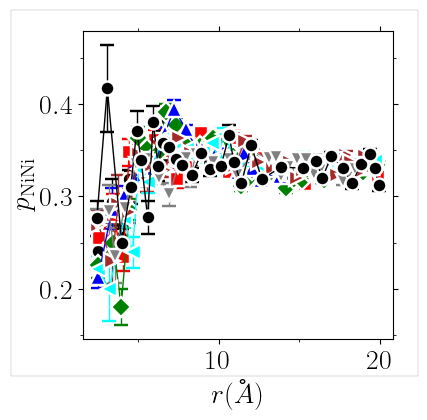

In [75]:
def main():
    
    if not eval(confParser['irradiation']['irradiation']) or\
    eval(confParser['flags']['RemoteMachine']):
        return
    
    pair='nicr'
    wc_indx = {'nini':(1,1),'nico':(1,2), 'nicr':(1,3)}[pair]

    
    #--- temporal average
    tmean = TimeAverage(
       [0,1,2,3,4,5,6,7],
        [list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1))],
        skip_frame = 1,
#         verbose = True,
                     )
    #--- parse data
    tmean.Parse( 'wc_pairi_%s_pairj_%s.txt'%wc_indx,
#                ['dislocations/sro'],
    list(map(lambda x:'nicocrNatom100KMultipleTempIrradiatedAnneal/dpa2/temp%s/Run%s/dislocations/sro'%(x[0],x[1]),
                         tmean.temps_runs ))
              )
    tmean.Print('wc_pairi_%s_pairj_%s_timeAveraged.txt'%wc_indx)

    #--- plot
    temp = Temperature(
       [0,1,2,3,4,5,6,7],
        [list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1)),list(range(1))],
#         verbose = True,
                     )
    #--- parse data
    temp.Parse( 'wc_pairi_%s_pairj_%s_timeAveraged.txt'%wc_indx,
#                ['dislocations/sro'],
    list(map(lambda x:'nicocrNatom100KMultipleTempIrradiatedAnneal/dpa2/temp%s/Run%s/dislocations/sro'%(x[0],x[1]),
                         temp.temps_runs ))
              )

    temp.EnsAverage()

    #    help(temp.Concatenate)
#    temp.Transform(col=0,multBy=-1,temp=invert)
#    temp.Transform(col=1,multBy=-1,temp=invert)

    #--- plot
     #--- plot
    temp.PlotPdf(shift=False,shift_factor=0.1/2,
                 rescale=False,alpha=1.5,
                 powerlaw=False, prefact=1e0,
#                  mylegends=[r'$1$',r'$10$',r'$10^2$',r'$10^3$'],
                 **{
                  'attrs':{'fmt':'-.r'},
#                  'xscale':'log',
#                  'yscale':'log',
#                   'xlim':(1e-2,10),
#                    'ylim':(1e-7,1e1),
#                    'ylim':(1e-7,1e2),
#                    'ndecade_y':1,'ndecade_x':1,
                     'xstr':r'$r(\r{A})$','ystr':r'$p_\mathrm{NiNi}$',
                    'nevery':1,
                   'title':'png/pdf_s_E1-4_cantor.png',
        'bbox_to_anchor':(0.55,0.45,0.5,0.5),
    
    })
    
    return temp

temp = main()

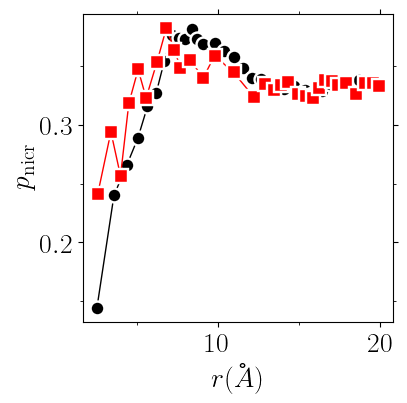

<AxesSubplot:xlabel='$r(\\r{A})$', ylabel='$p_\\mathrm{nicr}$'>

In [76]:
# pair='nicr'
# tmp_indx = 0


# legend = Legends()
# legend.Set()#bbox_to_anchor=(1,0.5,0.5,0.5))

# symbols = Symbols() 

# wc_indx = {'nini':0,'nico':1, 'nicr':2}[pair]
# path='nicocrNatom100KMultipleTempIrradiatedAnneal/benchmark/temp%s/Run0/orderParameter/pr_annealed_ij_index%s.txt'%(tmp_indx,wc_indx)

# sdata = np.loadtxt(path)

# ax = utl.PltErr(sdata[:,0],sdata[:,1],
#                 attrs=symbols.GetAttrs(count=0,label='$\mathrm{intact}(T=300 K)$'),

#                Plot=False,
#                )



# sdata =  temp.data_averaged[tmp_indx]
# utl.PltErr(sdata[:,0],sdata[:,1],
#           attrs=symbols.GetAttrs(count=1,label='$\mathrm{irradiated}$'),
#           ax=ax,
#           xstr=r'$r(\r{A})$',ystr=r'$p_\mathrm{%s}$'%pair,
# #           legend=legend.Get(),
#            title='png/wc_%s.png'%wc_indx,
#           )

